## This is HNA or Hybrid SFLA-CSO Network Aligner program, and implemented by Elham Mahdipour that is Ph.D. Candidate of Artificial Intelligence at Yazd University, Yazd, Iran. 
### All copyright reserved by the author.

You can run the program from first to end and see all the results, but since the population generation process can take a time depended on the node numbers of networks, you can use the populations stored in each program. We saved the populations as the pair of related species that you can see in the input folder and load them on program, such as "ce-sc-pop.pickle". Therefore, you must run follow steps: 1) Run all cells in "Load Graphs", "Swap Graphs", "Define Target Graph",and "Compute Score for create similarity matrix" sections. 2) If you will use saved population, please upload related pickle on root of jupyter notebook, then go "load population" cell and run them; else, please run "multi tasking for initial population", "multi processing for speed up", and "Initialization such as MeAlign" cells. 3) Run all remains cells to create results.

# load Graphs 

In [1]:
import pickle
with open('mm-mm-weighted.pickle', 'rb') as f:
    mmlist = pickle.load(f)

In [2]:
with open('hs-hs-weighted.pickle', 'rb') as f:
    hslist = pickle.load(f)

In [3]:
import networkx as nx
G1=nx.Graph()
for i in range(len(mmlist)):
    if G1.has_node(mmlist[i][0])==False:
        G1.add_node(mmlist[i][0])
    if G1.has_node(mmlist[i][1])==False:
        G1.add_node(mmlist[i][1])
    G1.add_edge(mmlist[i][0],mmlist[i][1],weight=mmlist[i][2])
G1

In [4]:
G2=nx.Graph()
for i in range(len(hslist)):
    if G2.has_node(hslist[i][0])==False:
        G2.add_node(hslist[i][0])
    if G2.has_node(hslist[i][1])==False:
        G2.add_node(hslist[i][1])
    G2.add_edge(hslist[i][0],hslist[i][1],weight=hslist[i][2])
G2

In [5]:
print('mm: len G1:', len(G1))

print('hs: len G2:',len(G2))

mm: len G1: 623
hs: len G2: 10399


# Swap graphs if len G1 > len G2

In [6]:
### Check and Swap if G1 > G2 ###
if len(G1)>len(G2):
    temp=G1
    G1=G2
    G2=temp
print(len(G1))
print(len(G2))

623
10399


In [7]:
ed1=G1.edges()

In [8]:
nd1=G1.nodes()

In [9]:
ed2=G2.edges()

In [10]:
len(ed2)

142847

In [11]:
nd2=G2.nodes()

In [12]:
len(ed1)

1760

In [13]:
len(nd1)

623

In [14]:
el1=list(ed1)
el2=list(ed2)

In [15]:
nd1=list(nd1)
nd2=list(nd2)

In [16]:
degG1 = [val for (node, val) in G1.degree()]


In [17]:
degG2 = [val for (node, val) in G2.degree()]

# Define Target Graph

In [18]:
G_target_na=nx.read_weighted_edgelist('hs-mm.evals')
G_target_na  

In [19]:
gtnode=list(G_target_na.nodes())
print(len(gtnode))
g_t_node=[]
for i in range(len(gtnode)):
    if (G1.has_node(gtnode[i])==False and G2.has_node(gtnode[i])==False):
        continue
    else:
        g_t_node.append(gtnode[i])

#print(gtnode)
print(len(g_t_node))

42012
10936


In [20]:
G_target=nx.Graph()
for i in range(len(g_t_node)):
    for j in range(len(g_t_node)):
        if G_target_na.has_node(g_t_node[i])==False:
            G_target.add_node(g_t_node[i])
        if G_target_na.has_node(g_t_node[j])==False:
            G_target.add_node(g_t_node[j])
        if G_target_na.has_edge(g_t_node[i],g_t_node[j]):
            a=list(G_target_na.get_edge_data(g_t_node[i],g_t_node[j]).values())            
            G_target.add_edge(g_t_node[i],g_t_node[j],weight=a[0])
G_target

In [21]:
len(G_target)

4853

In [22]:
G_target_na=G_target

# Compute Score for create similarity matrix


In [23]:
def deg_Diff(G1,G2):
    Degree_Difference=np.zeros((len(G1),len(G2)))
    for i in range(len(G1)):
        for j in range(len(G2)):
            Degree_Difference[i][j]=abs(degG1[i]-degG2[j])/max(degG1[i],degG2[j])
    return Degree_Difference

In [24]:
def score_pageRank(X):
    a=nx.pagerank(X)
    return a

In [25]:
def coefficient_pagerank(x,y):  #x is G1, y is G2
   # print(len(x))
    p1=score_pageRank(x)
    b=p1.values()
    pr1=list(b)
    p2=score_pageRank(y)
    c=p2.values()
    pr2=list(c)
    pr=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            #print(pr1[i],pr2[j])
            pr[i][j]=abs(pr1[i]-pr2[j])/max(pr1[i],pr2[j])   #minimum pr is maximum similarity of topology 
    return pr

In [26]:
def coefficient_edges(index_node, G, GraphNumber):
    if GraphNumber==1:
        sum_edge=0        
        for i in G.neighbors(nd1[index_node]):                       
            sum_edge=sum_edge+degG1[nd1.index(i)]
        #print(sum_edge)
        temp=(degG1[index_node]-1) if degG1[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG1[index_node]*temp)
    else:
        sum_edge=0        
        for i in G.neighbors(nd2[index_node]):                       
            sum_edge=sum_edge+degG2[nd2.index(i)]
        #print(sum_edge)
        temp=(degG2[index_node]-1) if degG2[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG2[index_node]*temp)
    return coeff_node
    

In [27]:
def compute_Ea(G1,G2):
    Ea_G1=np.zeros(len(G1))
    Ea_G2=np.zeros(len(G2))
    for i in range(len(G1)):
        Ea_G1[i]=coefficient_edges(i, G1, 1)
    for j in range(len(G2)):
        Ea_G2[j]=coefficient_edges(j,G2,2)
    ea=[Ea_G1, Ea_G2]
    return(ea)

In [28]:
# compute relative clustering coefficient difference between node a (in G1) and node b (in G2)
def CD(G1, G2):
    cd=np.zeros((len(G1),len(G2)))
    EA=compute_Ea(G1,G2)
    #print(EA[0])      #Ea for G1
    #print("===================")
    #print(EA[1])      #Ea for G2
    for i in range(len(G1)):
        for j in range(len(G2)):
            cd[i,j]=abs(EA[0][i]-EA[1][j])/max(EA[0][i],EA[1][j])
    return cd

In [29]:
def sequence_score(x,y):
    seq=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            q1=G_target_na.get_edge_data(str(nd1[i]),str(nd2[j]))
            if q1==None:
                c=0
            else:
                c=list(q1.values())
                c=c[0]
            seq[i][j]=c    
            
    return seq

In [30]:
def compute_score(G1,G2):
    coeff_pr=coefficient_pagerank(G1,G2)
    dd=deg_Diff(G1,G2)
    cd=CD(G1,G2)
    seq_sc=sequence_score(G1,G2)
    
    alpha=0.1
    betta=0.2
    gamma=0.2
    zetta=1-alpha-betta-gamma
    s=alpha*(1-coeff_pr)+betta*(1-dd)+gamma*(1-cd)+zetta*seq_sc
    return s

In [31]:
import numpy as np
m=compute_score(G1,G2)
n=m


In [32]:
m

array([[0.22318222, 0.11635542, 0.09986642, ..., 0.40599096, 0.40599096,
        0.40599096],
       [0.22318222, 0.11635542, 0.09986642, ..., 0.40599096, 0.40599096,
        0.40599096],
       [0.22318222, 0.11635542, 0.09986642, ..., 0.40599096, 0.40599096,
        0.40599096],
       ...,
       [0.22318222, 0.11635542, 0.09986642, ..., 0.40599096, 0.40599096,
        0.40599096],
       [0.22318222, 0.11635542, 0.09986642, ..., 0.40599096, 0.40599096,
        0.40599096],
       [0.22318222, 0.11635542, 0.09986642, ..., 0.40599096, 0.40599096,
        0.40599096]])

# multi tasking for initial population

In [33]:
def task1(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation):
    print('task1')
    for z1 in range(int(len_G1/3)):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])
  

In [34]:
def task2(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation):
    print('task2')
    for z1 in range(int(len_G1/3),int(2*len_G1/3)):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])
    

In [35]:
def task3(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation):
    print('task3')
    for z1 in range(int(2*len_G1/3),len_G1):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])
    

# multi processing for speed up

In [36]:
def fun_rand_permute(len_G1, base_permute, rand_permutation):
    for k in range(len_G1):
        rand_permutation[k]=random.sample(base_permute,len_G1)
    #print(rand_permutation)

# Initialization such as MeAlign

In [37]:
#%%prun
import random
import threading

len_pop=300 
len_G1=len(G1)
len_G2=len(G2)
similarity_score_matrix=np.zeros((len_G1,len_G1))
sim_score_matrix=np.zeros((len_G1,len_G1))
pop=np.zeros((len_pop,len_G1,2))
index_score=np.zeros(len_G1)
rand_permutation=np.zeros((len_G1,len_G1))
base_permute = [j for  j in range(0, len_G2)]

for i in range(len_pop):  
    print('wait')
    if i>0:
        do_not_permute = set(base_permute)-set(index_score)#[item for item in base_permute if item not in index_score]
        #print(do_not_permute)
        #print(len(base_permute))
        base_permute.extend(do_not_permute)
        #print(len(do_not_permute))
        #print(len(base_permute))
        #print(base_permute)
     
    t = threading.Thread(target=fun_rand_permute, args=(len_G1,base_permute, rand_permutation,))
    t.start() 
    t.join()
    #print(rand_permutation)
    
    """for k in range(len_G1):
        rand_permutation[k]=random.sample(base_permute,len_G1)                
    print('in for loop')
    for z1 in range(len_G1):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])"""
     
    
    t1 = threading.Thread(target=task1, args=(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation,)) 
    t2 = threading.Thread(target=task2, args=(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation,))
    t3 = threading.Thread(target=task3, args=(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation,))
    # starting thread 1 
    t1.start() 
    # starting thread 2 
    t2.start() 
    # starting thread 3 
    t3.start() 
    # wait until thread 1 is completely executed 
    t1.join() 
    # wait until thread 2 is completely executed 
    t2.join() 
    # wait until thread 3 is completely executed 
    t3.join()
    # both threads completely executed 
    print("Done!, i=",i) 
    
pop

wait
task1
task2
task3
Done!, i= 0
wait
task1
task2
task3
Done!, i= 1
wait
task1
task2
task3
Done!, i= 2
wait
task1
task2
task3
Done!, i= 3
wait
task1
task2
task3
Done!, i= 4
wait
task1
task2task3

Done!, i= 5
wait
task1
task2
task3
Done!, i= 6
wait
task1
task2
task3
Done!, i= 7
wait
task1
task2
task3
Done!, i= 8
wait
task1
task2
task3
Done!, i= 9
wait
task1
task2
task3
Done!, i= 10
wait
task1
task2
task3
Done!, i= 11
wait
task1
task2
task3
Done!, i= 12
wait
task1
task2
task3
Done!, i= 13
wait
task1
task2
task3
Done!, i= 14
wait
task1
task2task3

Done!, i= 15
wait
task1
task2
task3
Done!, i= 16
wait
task1
task2
task3
Done!, i= 17
wait
task1
task2
task3
Done!, i= 18
wait
task1
task2
task3
Done!, i= 19
wait
task1
task2
task3
Done!, i= 20
wait
task1
task2
task3
Done!, i= 21
wait
task1
task2
task3
Done!, i= 22
wait
task1
task2
task3
Done!, i= 23
wait
task1
task2
task3
Done!, i= 24
wait
task1
task2
task3
Done!, i= 25
wait
task1
task2
task3
Done!, i= 26
wait
task1
task2
task3
Done!, i= 27
wa

Done!, i= 224
wait
task1
task2
task3
Done!, i= 225
wait
task1
task2
task3
Done!, i= 226
wait
task1
task2
task3
Done!, i= 227
wait
task1
task2
task3
Done!, i= 228
wait
task1
task2
task3
Done!, i= 229
wait
task1task2

task3
Done!, i= 230
wait
task1
task2
task3
Done!, i= 231
wait
task1
task2
task3
Done!, i= 232
wait
task1
task2
task3
Done!, i= 233
wait
task1
task2
task3
Done!, i= 234
wait
task1
task2
task3
Done!, i= 235
wait
task1
task2
task3
Done!, i= 236
wait
task1
task2
task3
Done!, i= 237
wait
task1
task2
task3
Done!, i= 238
wait
task1
task2
task3
Done!, i= 239
wait
task1
task2
task3
Done!, i= 240
wait
task1
task2
task3
Done!, i= 241
wait
task1
task2
task3
Done!, i= 242
wait
task1
task2
task3
Done!, i= 243
wait
task1
task2
task3
Done!, i= 244
wait
task1
task2
task3
Done!, i= 245
wait
task1
task2
task3
Done!, i= 246
wait
task1
task2
task3
Done!, i= 247
wait
task1
task2
task3
Done!, i= 248
wait
task1
task2
task3
Done!, i= 249
wait
task1
task2
task3
Done!, i= 250
wait
task1
task2
task3
D

array([[[0.0000e+00, 3.5490e+03],
        [1.0000e+00, 1.0062e+04],
        [2.0000e+00, 9.9020e+03],
        ...,
        [6.2000e+02, 4.6770e+03],
        [6.2100e+02, 9.5180e+03],
        [6.2200e+02, 6.0660e+03]],

       [[0.0000e+00, 7.9760e+03],
        [1.0000e+00, 7.7990e+03],
        [2.0000e+00, 8.8460e+03],
        ...,
        [6.2000e+02, 8.5130e+03],
        [6.2100e+02, 1.0252e+04],
        [6.2200e+02, 5.1390e+03]],

       [[0.0000e+00, 8.7340e+03],
        [1.0000e+00, 4.4330e+03],
        [2.0000e+00, 7.8050e+03],
        ...,
        [6.2000e+02, 4.6770e+03],
        [6.2100e+02, 9.8030e+03],
        [6.2200e+02, 6.1360e+03]],

       ...,

       [[0.0000e+00, 9.7800e+03],
        [1.0000e+00, 9.0270e+03],
        [2.0000e+00, 8.9720e+03],
        ...,
        [6.2000e+02, 4.6850e+03],
        [6.2100e+02, 5.9240e+03],
        [6.2200e+02, 1.0093e+04]],

       [[0.0000e+00, 9.0060e+03],
        [1.0000e+00, 9.5470e+03],
        [2.0000e+00, 7.4200e+03],
        .

# save population

In [42]:
import pickle
with open('hs-mm-base_permute.pickle', 'wb') as f:
    pickle.dump(base_permute, f)

In [43]:
import pickle
with open('hs-mm-pop.pickle', 'wb') as f:
    pickle.dump(pop, f)

# load population

In [ ]:
with open('hs-mm-base_permute', 'rb') as f:
    base_permute = pickle.load(f)

In [ ]:
with open('hs-mm-pop.pickle', 'rb') as f:
    pop = pickle.load(f)

# compute measure edge correctness, ics, nc and s3

In [38]:
def induced_function_for_initialpop(sub_pop):
    num_induced=0
    sub_g2=list(set([sub_pop[i][1] for i in range(len(G1))]))
    for i in range(len(sub_g2)):
        for j in range(i,len(sub_g2)):
            if G2.has_edge(nd2[int(sub_g2[i])], nd2[int(sub_g2[j])]):
                num_induced=num_induced+1
    return num_induced

In [39]:
score_ec=np.zeros(len_pop)
score_ics=np.zeros(len_pop)
score_s3=np.zeros(len_pop)
score_nc=np.zeros(len_pop)
num_seq=np.zeros(len_pop)
score_ncorectness=np.zeros(len_pop)

p=pop 
len_G1=len(G1)
map_items=[] #np.zeros((len_pop,len_G1,2))

for i in range(len(p)):
    ec=0
    nc=0
    sub_pop=p[i]
    sub_g2=list(set([sub_pop[i][1] for i in range(len(G1))]))
    num_induced=induced_function_for_initialpop(sub_pop) 
    #print("number induced for i=",i," is: ",num_induced)
    
    for j in range(len_G1):                            
         if G_target_na.has_edge(nd1[int(p[i][j][0])],nd2[int(p[i][j][1])]):
            num_seq[i]+=1  # create sequence matrix 
            map_items.append([nd1[int(p[i][j][0])],nd2[int(p[i][j][1])]])
            ec=ec+1            
            nc=nc+2
                 
    score_ec[i]=ec/G1.number_of_edges()*100
    score_ics[i]=ec/num_induced*100
    score_s3[i]=ec/(G1.number_of_edges()+num_induced-ec)*100
    score_nc[i]=nc/G1.number_of_nodes()*100 
    score_ncorectness[i]=(nc/G_target_na.number_of_nodes())*100
    print('done i=',i)
    """if (score_nc[i] > 100):
        score_nc[i]=100
    if (score_ec[i] > 100):
        score_ec[i]=100
    if (score_ics[i] > 100):
        score_ics[i]=100
    if (score_s3[i] > 100):
        score_s3[i]=100
    if ( score_ncorectness[i]>100):
         score_ncorectness[i]=100"""

print('ec')
print(score_ec)
print('ics')
print(score_ics)
print('s3')
print(score_s3)
print('nc',score_nc)
print('node correctness: ',  score_ncorectness)

done i= 0
done i= 1
done i= 2
done i= 3
done i= 4
done i= 5
done i= 6
done i= 7
done i= 8
done i= 9
done i= 10
done i= 11
done i= 12
done i= 13
done i= 14
done i= 15
done i= 16
done i= 17
done i= 18
done i= 19
done i= 20
done i= 21
done i= 22
done i= 23
done i= 24
done i= 25
done i= 26
done i= 27
done i= 28
done i= 29
done i= 30
done i= 31
done i= 32
done i= 33
done i= 34
done i= 35
done i= 36
done i= 37
done i= 38
done i= 39
done i= 40
done i= 41
done i= 42
done i= 43
done i= 44
done i= 45
done i= 46
done i= 47
done i= 48
done i= 49
done i= 50
done i= 51
done i= 52
done i= 53
done i= 54
done i= 55
done i= 56
done i= 57
done i= 58
done i= 59
done i= 60
done i= 61
done i= 62
done i= 63
done i= 64
done i= 65
done i= 66
done i= 67
done i= 68
done i= 69
done i= 70
done i= 71
done i= 72
done i= 73
done i= 74
done i= 75
done i= 76
done i= 77
done i= 78
done i= 79
done i= 80
done i= 81
done i= 82
done i= 83
done i= 84
done i= 85
done i= 86
done i= 87
done i= 88
done i= 89
done i= 90
done i= 9

## number of matched sequences 

In [40]:
num_seq

array([324., 328., 332., 315., 334., 325., 321., 332., 342., 334., 333.,
       346., 332., 345., 321., 323., 321., 329., 339., 343., 328., 331.,
       331., 332., 329., 332., 337., 326., 326., 339., 341., 327., 331.,
       331., 341., 354., 339., 327., 335., 342., 345., 328., 332., 347.,
       341., 325., 327., 317., 338., 327., 337., 340., 336., 341., 330.,
       332., 312., 335., 323., 323., 345., 312., 331., 313., 324., 337.,
       329., 332., 352., 321., 340., 335., 321., 332., 329., 338., 327.,
       321., 335., 315., 326., 319., 320., 321., 328., 326., 337., 348.,
       322., 324., 323., 334., 325., 338., 316., 315., 319., 341., 324.,
       321., 321., 328., 335., 332., 332., 321., 326., 343., 317., 320.,
       344., 341., 309., 329., 338., 333., 328., 329., 337., 313., 324.,
       318., 358., 349., 340., 333., 341., 329., 338., 320., 342., 357.,
       345., 345., 339., 346., 335., 335., 323., 327., 329., 325., 334.,
       326., 333., 327., 346., 341., 352., 335., 32

## compute topology score

In [41]:
#compute Final Score
tscore=np.zeros(len_pop)
for i in range(len(p)):
    tscore[i]=(0.25*(score_ec[i]/G1.number_of_edges())+0.25*(score_s3[i]/(G1.number_of_edges()+score_ics[i]-score_ec[i]))+0.25*(score_ics[i]/2*G1.number_of_edges())+0.25*(score_nc[i]/(G1.number_of_nodes()+G2.number_of_nodes())))
print(tscore)

[3993.2837141  4613.81733028 4773.86289783 4669.81768147 4563.98184406
 4346.51104652 4535.65192    4528.21495372 4714.29257473 4496.94670128
 4533.42250683 4415.32010279 4640.41327326 4415.36462594 4827.07416517
 4298.85701731 4410.99955572 4418.80999124 4530.99097741 4349.28635022
 4454.32754837 4034.3555663  4514.57575155 4448.24049305 4473.43056242
 4652.2359673  4565.27767928 4547.88225427 4536.37592536 4394.82112648
 4026.84514451 4501.8838977  4448.38779897 4531.43164424 4585.58139145
 4828.27740234 4506.35117967 4585.09260754 4397.38137836 4610.30095952
 4367.09545817 4498.75968579 3960.96098581 4402.54437881 4428.57821901
 4824.5679725  4473.88714311 4456.23639367 4604.34113373 4961.38593804
 4627.97179817 4487.10936278 4622.89604126 4858.81515751 4662.81973549
 4459.10309296 4414.15417372 4532.60202724 4351.50675824 4560.98209838
 4726.03431423 4428.39336293 4464.75217168 4643.29694693 4255.52884077
 4318.00320334 4537.93762807 4658.16993427 4595.85271707 4122.59831822
 4197.

# Compute Topology and Sequence score

In [44]:
# Final Score
score=np.zeros(len_pop)
alpha=0.5
for i in range (len(p)):
    score[i]=alpha*tscore[i]+(1-alpha)*num_seq[i]   
score

array([2158.64185705, 2470.90866514, 2552.93144892, 2492.40884073,
       2448.99092203, 2335.75552326, 2428.32596   , 2430.10747686,
       2528.14628737, 2415.47335064, 2433.21125341, 2380.6600514 ,
       2486.20663663, 2380.18231297, 2574.03708258, 2310.92850865,
       2365.99977786, 2373.90499562, 2434.99548871, 2346.14317511,
       2391.16377419, 2182.67778315, 2422.78787577, 2390.12024652,
       2401.21528121, 2492.11798365, 2451.13883964, 2436.94112713,
       2431.18796268, 2366.91056324, 2183.92257226, 2414.44194885,
       2389.69389948, 2431.21582212, 2463.29069572, 2591.13870117,
       2422.67558983, 2456.04630377, 2366.19068918, 2476.15047976,
       2356.04772908, 2413.37984289, 2146.4804929 , 2374.7721894 ,
       2384.7891095 , 2574.78398625, 2400.44357155, 2386.61819683,
       2471.17056686, 2644.19296902, 2482.48589909, 2413.55468139,
       2479.44802063, 2599.90757876, 2496.40986775, 2395.55154648,
       2363.07708686, 2433.80101362, 2337.25337912, 2441.99104

## Define function for fitness and compute final score

In [45]:
def induced_function_for_pop(wpop):
    counter_induced=0
    subg=list(set([wpop[i][1] for i in range(len_G1)]))
    for i in range(len(subg)):
        for j in range(i,len(subg)):
            if G2.has_edge(nd2[int(subg[i])], nd2[int(subg[j])]):
                counter_induced=counter_induced+1
    #print("con: ",counter_induced)
    return counter_induced

In [46]:
def Fitness(wpop, counter_induced):
    ec_temp=0
    nc_temp=0
    num_seq_temp=0
    score_ncorectness=0
    
    for j in range(len_G1):        
        x1=int(wpop[j][0])
        x2=int(wpop[j][1])
        if G_target_na.has_edge(nd1[x1],nd2[x2]):
            num_seq_temp+=1              
            ec_temp=ec_temp+1            
            nc_temp=nc_temp+2
                 
    score_ec_temp=ec_temp/G1.number_of_edges()*100
    score_ics_temp=ec_temp/counter_induced*100
    score_s3_temp=ec_temp/(G1.number_of_edges()+counter_induced-ec_temp)*100
    score_nc_temp=nc_temp/G1.number_of_nodes()*100
    score_ncorectness=(nc_temp/G_target_na.number_of_nodes())*100
    """if (score_nc_temp > 100):
        score_nc_temp=100
    if (score_ec_temp > 100):
        score_ec_temp=100
    if (score_ics_temp > 100):
        score_ics_temp=100
    if (score_s3_temp > 100):
        score_s3_temp=100
    if ( score_ncorectness>100):
         score_ncorectness=100"""
    # local measures
    pre=ec_temp/G_target_na.number_of_edges()*100
    rec=ec_temp/len(wpop)*100
    fsc=(2*(pre*rec)/(pre+rec))
    
    if (GbestFlag==True):
        print('ec')
        print(score_ec_temp)
        print('ics')
        print(score_ics_temp)
        print('s3')
        print(score_s3_temp)
        print('nc',score_nc_temp)
        print('node correctness:',score_ncorectness)
        print('num_seq',num_seq_temp)
        print('precision: ',pre)
        print('Recall: ',rec)
        print('F-score: ',fsc)

    alpha=0.5
    tscore_temp=(0.25*(score_ec_temp/G1.number_of_edges())+0.25*(score_s3_temp/(G1.number_of_edges()+score_ics_temp-score_ec_temp))+0.25*(score_ics_temp/2*G1.number_of_edges())+0.25*(score_nc_temp/(G1.number_of_nodes()+G2.number_of_nodes())))
    score_temp=alpha*tscore_temp+(1-alpha)*num_seq_temp
    print('score:',score_temp)
    
    return score_temp,pre,rec,fsc

# HNA: Hybrid SFLA-CSO proposed method

In [47]:
# Implementation of Hybrid SFLA-CSO Algorithm
import random
from operator import itemgetter
from random import shuffle
import concurrent.futures

precision=np.zeros(len_pop)
recall=np.zeros(len_pop)
fscore=np.zeros(len_pop)


dim=len_G1
new_pop=p.tolist()
[new_pop[i].append(score[i]) for i in range(len_pop)]
#[print(new_pop[i][dim]) for i in range(len_pop)]

new_pop=sorted(new_pop, key=itemgetter(dim),reverse=True)
counter_induced=num_induced #0

GBestFrog=new_pop[0]
#print("GBest: ",GBestFrog)

index=0
iteration=2
epoch=0
memeplex=100
GbestFlag=False

group=int(len_pop/memeplex)
len_G1=len(G1)
dim=len_G1

max_score=max(score)
while (epoch<5):
    k=u=0
    #==== Set memeplexes =====
    memp=[]
    memp.append([new_pop[0],new_pop[memeplex],new_pop[2*memeplex]]) #,pop[3*memeplex],pop[4*memeplex]])
    for i in range(1,memeplex):    
        memp.append([new_pop[i],new_pop[i+memeplex],new_pop[i+2*memeplex]]) #,pop[i+3*memeplex],pop[i+4*memeplex]])
    #print('Check memeplex')
    #[[print(memp[i][j][dim]) for j in range(group)]for i in range(memeplex)]
    #=== Local Search =====   
    while(k<memeplex):
        u=0
        print("k ",k)
        print("epoch ",epoch)
        while(u<iteration):
            print("u ",u)
            memp[k]=sorted(memp[k], key=itemgetter(dim),reverse=True)
            #print('Check sort memeplex')
            #[[print(memp[i][j][dim]) for j in range(group)]for i in range(memeplex)]
            #=== set best frog and worst frog 
            bestFrog=memp[k][0]
            worstFrog=memp[k][group-1]            
            #print("BestFrog",bestFrog[dim])
            #print("WorstFrog",worstFrog[dim])
            r1=random.random()
            c1=2
            TeV=(worstFrog[dim]+r1*c1*(bestFrog[dim]-worstFrog[dim]))/100             #number of permutation
           # print(TeV)
                       
            # move 1
            temp_worst=worstFrog    #temp_worst is TeX
            
            Flag_move1=False
            
            # counter induced for ics compute            
            """with concurrent.futures.ThreadPoolExecutor() as executor:
                future = executor.submit(induced_function_for_pop, temp_worst)
                counter_induced = future.result()
                #print("counter induced: ",counter_induced)"""
            
            for i in range(int(TeV)):
                rand_index1=random.randint(0,dim-1)
                rand_permute=random.sample(base_permute,len_G1)                
                #print('rand1',rand_index1)                                
                if not(G_target_na.has_edge(temp_worst[rand_index1][0],temp_worst[rand_index1][1])):                                                 
                        temp_score=np.argmax(m[rand_index1])
                        #print(nd2[temp_score])                        
                        #print('temp:',G_target_na.has_edge(nd1[int(temp_worst[rand_index1][0])],nd2[temp_score]))
                        if(G_target_na.has_edge(nd1[int(temp_worst[rand_index1][0])],nd2[temp_score])):                                
                                temp_worst[rand_index1][1]=temp_score
                                Fit_New,pre,rec,fsc=Fitness(temp_worst,counter_induced)     
                                if(Fit_New>worstFrog[dim]):
                                    print('w',worstFrog[dim])
                                    print('new',Fit_New)
                                    temp_worst[dim]=Fit_New
                                    memp[k][group-1]=temp_worst 
                                    Flag_move1=True
                                    print('move1 ', TeV)                                                                 
            #======== move 2 =======
            Flag_move2=False
            
            if(Flag_move1==False):
                    TeV=(worstFrog[dim]+r1*c1*(GBestFrog[dim]-worstFrog[dim]))/100   #number of random permutation                
                            #print(TeV)                
           
                    temp_worst=worstFrog    #temp_worst is TeX               
                
                    for i in range(int(TeV)):
                        rand_permute=random.sample(base_permute,len_G1)
                        rand_index1=random.randint(0,dim-1)
                        if not(G_target_na.has_edge(temp_worst[rand_index1][0],temp_worst[rand_index1][1])):                            
                            temp_score=np.argmax(m[rand_index1])
                            #print(nd2[temp_score])
                            #print('temp:',G_target_na.has_edge(nd1[int(temp_worst[rand_index1][0])],nd2[temp_score]))
                            if(G_target_na.has_edge(temp_worst[rand_index1][0],nd2[temp_score])):                                
                                temp_worst[rand_index1][1]=temp_score                                                                   
                                Fit_New,pre,rec,fsc=Fitness(temp_worst,counter_induced)     
                                if(Fit_New>worstFrog[dim]):
                                    print('w',worstFrog[dim])
                                    print('new',Fit_New)
                                    temp_worst[dim]=Fit_New
                                    memp[k][group-1]=temp_worst 
                                    Flag_move2=True
                                    print('move2 ', TeV)                                                                      
                    #===== move 3 =====
            
            if(Flag_move1==False and Flag_move2==False):
                TeV=(worstFrog[dim]*random.random()*2)/100             #number of permutation
                                            # print(TeV)
                              
                temp_worst=worstFrog   #temp_worst is TeX                    
                for i in range(int(TeV)):
                    rand_permute=random.sample(base_permute,len_G1)
                    rand_index1=random.randint(0,dim-1) 
                    if not(G_target_na.has_edge(temp_worst[rand_index1][0],temp_worst[rand_index1][1])):                        
                        temp_score=np.argmax(m[rand_index1])
                        #print(nd2[temp_score])
                        #print('temp:',G_target_na.has_edge(nd1[int(temp_worst[rand_index1][0])],nd2[temp_score]))
                        if (G_target_na.has_edge(temp_worst[rand_index1][0],nd2[temp_score])):                                                    
                            temp_worst[rand_index1][1]=temp_score                            
                            Fit_New,pre,rec,fsc=Fitness(temp_worst,counter_induced)     
                            if(Fit_New>worstFrog[dim]):
                                print('w',worstFrog[dim])
                                print('new',Fit_New)
                                temp_worst[dim]=Fit_New
                                memp[k][group-1]=temp_worst  
                                print('move3 ',TeV)
                
            u=u+1
        k=k+1    
    epoch+=1
    #==== combine memeplexes and create new pop ====
    print('*********** fitness **************')    
    new_pop=[]
    for i in range(memeplex):
        for j in range(group):        
            del memp[i][j][dim]
       
    [[new_pop.append(memp[i][j]) for j in range(group)] for i in range(memeplex)]         
    
    for i in range(len_pop):
        Fit,pre,rec,fsc=Fitness(new_pop[i],counter_induced)
        print('Fit pop',Fit)
        new_pop[i].append(Fit)
        score[i]=Fit
        precision[i]=pre
        recall[i]=rec
        fscore[i]=fsc
    
    
    new_pop=sorted(new_pop, key=itemgetter(dim), reverse=True)
    print('********** new population ************')
    [print('Fitness: ',new_pop[i][dim]) for i in range(len_pop)]
    
    GBestFrog=new_pop[0]
    
print("GBest: ",GBestFrog)    
print("epoch: ",epoch)
print("score:", score)
#********** print Local Measures *********
print("Precision: ",precision)
print("Recall: ", recall)
print("F-measure: ",fscore)
#******** map items **********
map_items=[]
weight=[]
for i in range(len_pop):
    for j in range(len_G1):
        if G_target_na.has_edge(nd1[int(new_pop[i][j][0])],nd2[int(new_pop[i][j][1])]):
            map_items.append([nd1[int(new_pop[i][j][0])],nd2[int(new_pop[i][j][1])]]) 
            weight.append(G_target_na.get_edge_data(nd1[int(new_pop[i][j][0])],nd2[int(new_pop[i][j][1])])) 

print("end")

k  0
epoch  0
u  0
score: 2201.76651558479
score: 2201.76651558479
score: 2201.76651558479
score: 2208.647036173265
score: 2215.5275567633
score: 2222.4080773548953
score: 2222.4080773548953
score: 2229.288597948055
score: 2236.1691185427794
score: 2236.1691185427794
score: 2236.1691185427794
score: 2243.04963913907
score: 2243.04963913907
score: 2249.930159736928
score: 2256.810680336355
score: 2263.691200937353
score: 2263.691200937353
score: 2270.571721539923
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2284.3327627497847
score: 2284.3327627497847
score: 2284.3327627497847
score: 2284.3327627497847
score: 2291.213283357081
score: 2298.093803965954
u  1
score: 2298.093803965954
score: 2304.9743245764075
score: 2304.9743245764075
score: 2304.9743245764075
score: 2311.854845188441
score: 2311.854845188441
score: 2311.854845188441
score: 2311.854845188441
score: 2311.854

score: 2325.615886417259
score: 2332.4964070340457
score: 2332.4964070340457
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
k  5
epoch  0
u  0
score: 2373.779530768149
w 2344.7987865995738
new 2373.779530768149
move1  26.067464204141885
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  26.067464204141885
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  26.067464204141885
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  26.067464204141885
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  26.067464204141885
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  26.067464204141885
score: 2408.1821339237863
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  26.067464204141885
score: 2421.9431751972575
w

score: 2332.4964070340457
score: 2332.4964070340457
score: 2332.4964070340457
score: 2339.3769276524195
w 2336.7721870480605
new 2339.3769276524195
move1  24.25276856688928
score: 2339.3769276524195
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  24.25276856688928
score: 2346.2574482723817
score: 2346.2574482723817
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  24.25276856688928
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  24.25276856688928
score: 2360.018489517079
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  24.25276856688928
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  24.25276856688928
score: 2373.779530768149
score: 2373.779530768149
score: 2380.6600513960775
w 2373.779530768149
new 2380.66

score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  27.288881623378266
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  27.288881623378266
k  14
epoch  0
u  0
score: 2236.1691185427794
score: 2243.04963913907
score: 2243.04963913907
score: 2249.930159736928
score: 2256.810680336355
score: 2263.691200937353
score: 2270.571721539923
score: 2270.571721539923
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2284.3327627497847
score: 2284.3327627497847
score: 2284.3327627497847
score: 2284.3327627497847
score: 2284.3327627497847
score: 2291.213283357081
score: 2298.093803965954
score: 2298.093803965954
score: 2298.093803965954
score: 2298.093803965954
score: 2298.093803965954
score: 2298.093803965954
score: 2298.093803965954
score: 2304.9743245764075
score: 2304.9743245764075
u  1
score: 2311.854845188441
score: 2311.854845188441
score: 2311.854845188441
score: 2318.735365802058
score: 2325.615886417259
score:

score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  23.352447650998187
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  23.352447650998187
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  23.352447650998187
score: 2387.5405720256044
score: 2387.5405720256044
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  23.352447650998187
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  23.352447650998187
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  23.352447650998187
u  1
score: 2408.1821339237863
score: 2408.1821339237863
score: 2408.1821339237863
score: 2408.1821339237863
score: 2408.1821339237863
score: 2408.1821339237863
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  25.4536

score: 2346.2574482723817
score: 2346.2574482723817
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  26.323027803865457
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  26.323027803865457
score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  26.323027803865457
k  23
epoch  0
u  0
score: 2243.04963913907
score: 2249.930159736928
score: 2256.810680336355
score: 2256.810680336355
score: 2256.810680336355
score: 2263.691200937353
score: 2263.691200937353
score: 2270.571721539923
score: 2270.571721539923
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2284.3327627497847
score: 2284.3327627497847
score: 2284.3327627497847
score: 2284.3327627497847
score: 2284.3327627497847
score: 2291.213283357081
score: 2298.093803965954
score: 2298.093803965954
score: 2298.

score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  25.81054451435989
score: 2408.1821339237863
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  25.81054451435989
score: 2415.0626545597192
score: 2415.0626545597192
score: 2415.0626545597192
score: 2415.0626545597192
u  1
score: 2236.1691185427794
score: 2243.04963913907
score: 2243.04963913907
score: 2249.930159736928
score: 2256.810680336355
score: 2256.810680336355
score: 2263.691200937353
score: 2263.691200937353
score: 2270.571721539923
score: 2270.571721539923
score: 2277.4522421440665
score: 2277.4522421440665
score: 2284.3327627497847
score: 2284.3327627497847
score: 2284.3327627497847
score: 2291.213283357081
score: 2298.093803965954
score: 2304.9743245764075
score: 2304.9743245764075
score: 2311.854845188441
score: 2311.854845188441
score: 2318.735365802058
k  27
epoch  0
u  0
score: 2318.735365802058
w 2315.591949048611
new 2318.735365802058
move1 

score: 2256.810680336355
score: 2256.810680336355
score: 2263.691200937353
score: 2263.691200937353
score: 2270.571721539923
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2284.3327627497847
score: 2291.213283357081
score: 2298.093803965954
score: 2298.093803965954
score: 2304.9743245764075
score: 2304.9743245764075
score: 2304.9743245764075
score: 2304.9743245764075
k  31
epoch  0
u  0
score: 2291.213283357081
score: 2291.213283357081
score: 2291.213283357081
score: 2298.093803965954
score: 2304.9743245764075
score: 2311.854845188441
score: 2311.854845188441
score: 2311.854845188441
score: 2311.854845188441
score: 2311.854845188441
score: 2318.735365802058
w 2312.3732578229046
new 2318.735365802058
move1  26.02676358411117
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  26.02676358411117
score:

score: 2325.615886417259
score: 2325.615886417259
score: 2325.615886417259
score: 2325.615886417259
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  26.278154777647895
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  26.278154777647895
score: 2339.3769276524195
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  26.278154777647895
score: 2346.2574482723817
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  26.278154777647895
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  26.278154777647895
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  26.278154777647895
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  26.278154777647895
score: 2373.779530768149
u  1
score: 2373.779530768149
score: 2373.779530768149
score: 2373.779530768149
score: 2380.6600513960775
w 2373.779530768149
new 2380.

score: 2270.571721539923
score: 2270.571721539923
score: 2277.4522421440665
score: 2277.4522421440665
score: 2284.3327627497847
score: 2284.3327627497847
score: 2291.213283357081
score: 2298.093803965954
score: 2298.093803965954
score: 2304.9743245764075
score: 2311.854845188441
score: 2311.854845188441
score: 2318.735365802058
score: 2318.735365802058
score: 2325.615886417259
score: 2332.4964070340457
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
k  39
epoch  0
u  0
score: 2188.0054744125164
score: 2194.885994997874
score: 2194.885994997874
score: 2194.885994997874
score: 2201.76651558479
score: 2201.76651558479
score: 2208.647036173265
score: 2208.647036173265
score: 2215.5275567633
score: 2222.4080773548953
score: 2222.4080773548953
score: 2229.288597948055
score: 2236.1691185427794
score: 2236.169

score: 2298.093803965954
score: 2298.093803965954
score: 2298.093803965954
score: 2298.093803965954
score: 2298.093803965954
score: 2304.9743245764075
w 2298.093803965954
new 2304.9743245764075
move1  26.262907451117115
score: 2304.9743245764075
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  26.262907451117115
u  1
score: 2311.854845188441
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  26.943353375803046
score: 2318.735365802058
score: 2318.735365802058
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  26.943353375803046
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  26.943353375803046
score: 2332.4964070340457
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  26.943353375803046
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  26.943353375803046
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  26.943

score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  25.55952663025731
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  25.55952663025731
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  25.55952663025731
score: 2449.4652577634974
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  25.55952663025731
k  47
epoch  0
u  0
score: 2325.615886417259
w 2286.789055420048
new 2325.615886417259
move1  24.29723260977114
score: 2325.615886417259
score: 2325.615886417259
score: 2325.615886417259
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  24.29723260977114
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  24.29723260977114
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  24.29723260977114
score: 2346.2574482723817
score: 2353.137968893935


score: 2408.1821339237863
score: 2408.1821339237863
score: 2408.1821339237863
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.239944400055432
k  52
epoch  0
u  0
score: 2201.76651558479
score: 2208.647036173265
score: 2208.647036173265
score: 2208.647036173265
score: 2208.647036173265
score: 2215.5275567633
score: 2215.5275567633
score: 2222.4080773548953
score: 2222.4080773548953
score: 2229.288597948055
score: 2229.288597948055
score: 2229.288597948055
score: 2229.288597948055
score: 2236.1691185427794
score: 2243.04963913907
score: 2249.930159736928
score: 2249.930159736928
score: 2249.930159736928
score: 2249.930159736928
score: 2256.810680336355
score: 2256.810680336355
score: 2263.691200937353
score: 2270.571721539923
u  1
score: 2270.571721539923
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2284.3327627497847
w 2281.7632857212784
new 2284.3327627497847
move1  23.76431172531607
score: 2284.3327627497847
score

u  1
score: 2263.691200937353
score: 2270.571721539923
score: 2277.4522421440665
w 2276.769198833884
new 2277.4522421440665
move1  26.5334128898807
score: 2284.3327627497847
w 2277.4522421440665
new 2284.3327627497847
move1  26.5334128898807
score: 2284.3327627497847
score: 2284.3327627497847
score: 2291.213283357081
w 2284.3327627497847
new 2291.213283357081
move1  26.5334128898807
score: 2291.213283357081
score: 2291.213283357081
score: 2291.213283357081
score: 2291.213283357081
score: 2298.093803965954
w 2291.213283357081
new 2298.093803965954
move1  26.5334128898807
score: 2298.093803965954
score: 2298.093803965954
score: 2304.9743245764075
w 2298.093803965954
new 2304.9743245764075
move1  26.5334128898807
score: 2304.9743245764075
score: 2304.9743245764075
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  26.5334128898807
score: 2311.854845188441
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  26.5334128898807
score: 2318.73536580

score: 2304.9743245764075
u  1
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  24.444749308892543
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  24.444749308892543
score: 2318.735365802058
score: 2318.735365802058
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  24.444749308892543
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  24.444749308892543
score: 2332.4964070340457
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  24.444749308892543
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  24.444749308892543
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  24.444749308892543
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 

score: 2325.615886417259
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  25.59206741119345
score: 2332.4964070340457
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  25.59206741119345
score: 2339.3769276524195
score: 2339.3769276524195
u  1
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  25.237428264065038
score: 2346.2574482723817
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  25.237428264065038
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  25.237428264065038
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  25.237428264065038
score: 2366.8990101418167
score: 2366.8990101418167
score: 2366.8990101418167
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  25.237428264065038
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  25.237428264065038
score:

score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  25.13439102671809
score: 2332.4964070340457
score: 2332.4964070340457
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  25.13439102671809
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  25.13439102671809
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  25.13439102671809
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  25.13439102671809
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  25.13439102671809
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  25.13439102671809
score: 2373.779530768149
k  70
epoch  0
u  0
score: 2194.885994997874
score: 2194.885994997874
score: 2201.7665155

score: 2263.691200937353
score: 2270.571721539923
w 2263.691200937353
new 2270.571721539923
move1  25.533778883046022
score: 2270.571721539923
score: 2270.571721539923
score: 2270.571721539923
score: 2270.571721539923
score: 2270.571721539923
score: 2270.571721539923
score: 2270.571721539923
score: 2270.571721539923
score: 2270.571721539923
score: 2270.571721539923
score: 2277.4522421440665
w 2270.571721539923
new 2277.4522421440665
move1  25.533778883046022
score: 2284.3327627497847
w 2277.4522421440665
new 2284.3327627497847
move1  25.533778883046022
score: 2291.213283357081
w 2284.3327627497847
new 2291.213283357081
move1  25.533778883046022
u  1
score: 2291.213283357081
score: 2298.093803965954
w 2291.213283357081
new 2298.093803965954
move1  24.471817238149352
score: 2304.9743245764075
w 2298.093803965954
new 2304.9743245764075
move1  24.471817238149352
score: 2304.9743245764075
score: 2304.9743245764075
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  24

move1  24.35692431566133
score: 2311.854845188441
score: 2311.854845188441
score: 2311.854845188441
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  24.35692431566133
score: 2318.735365802058
score: 2318.735365802058
score: 2318.735365802058
score: 2318.735365802058
score: 2318.735365802058
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  24.35692431566133
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  24.35692431566133
score: 2332.4964070340457
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  24.35692431566133
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  24.35692431566133
score: 2346.2574482723817
score: 2346.2574482723817
u  1
score: 2346.2574482723817
score: 2346.2574482723817
score: 2346.2574482723817
score: 2346.2574482723817
score: 2353.1379

score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  25.25992005567242
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  25.25992005567242
score: 2346.2574482723817
score: 2346.2574482723817
score: 2346.2574482723817
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  25.25992005567242
score: 2353.137968893935
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  25.25992005567242
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  25.25992005567242
score: 2366.8990101418167
score: 2366.8990101418167
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  25.25992005567242
score: 2373.779530768149
k  83
epoch  0
u  0
score: 2222.4080773548953
w 2221.2133496676497
new 2222.4080773548953
move1  22.34489225529009
score: 2229.288597948055
w 2222.4080773548953
new 2229.288597948055
move1  22.34489225529009

score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  22.756059415813496
score: 2353.137968893935
score: 2353.137968893935
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  22.756059415813496
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  22.756059415813496
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  22.756059415813496
score: 2373.779530768149
score: 2373.779530768149
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  22.756059415813496
score: 2380.6600513960775
u  1
score: 2408.1821339237863
w 2366.2385312995566
new 2408.1821339237863
move1  24.469649520401475
score: 2408.1821339237863
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.469649520401475
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.469649520401475
score: 2428.823695836403
w 2421.9

score: 2325.615886417259
score: 2332.4964070340457
score: 2332.4964070340457
score: 2339.3769276524195
score: 2346.2574482723817
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2360.018489517079
k  90
epoch  0
u  0
score: 2201.76651558479
w 2188.99998223481
new 2201.76651558479
move1  24.930470119195974
score: 2201.76651558479
score: 2201.76651558479
score: 2208.647036173265
w 2201.76651558479
new 2208.647036173265
move1  24.930470119195974
score: 2215.5275567633
w 2208.647036173265
new 2215.5275567633
move1  24.930470119195974
score: 2222.4080773548953
w 2215.5275567633
new 2222.4080773548953
move1  24.930470119195974
score: 2222.4080773548953
score: 2229.288597948055
w 2222.4080773548953
new 2229.288597948055
move1  24.930470119195974
score: 2229.288597948055
score: 2229.288597948055
score: 2229.288597948055
score: 2229.288597948055
score: 2229.288597948055
score: 2229.288597948055
score: 2236.1691185427794
w 2229.28859794805

score: 2236.1691185427794
score: 2243.04963913907
score: 2249.930159736928
score: 2256.810680336355
score: 2256.810680336355
score: 2263.691200937353
score: 2270.571721539923
score: 2270.571721539923
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2277.4522421440665
score: 2284.3327627497847
score: 2291.213283357081
score: 2298.093803965954
score: 2304.9743245764075
k  95
epoch  0
u  0
score: 2208.647036173265
w 2163.339250926987
new 2208.647036173265
move1  27.068838989386975
score: 2208.647036173265
score: 2208.647036173265
score: 2208.647036173265
score: 2215.5275567633
w 2208.647036173265
new 2215.5275567633
move1  27.068838989386975
score: 2222.4080773548953
w 2215.5275567633
new 2222.4080773548953
move1  27.068838989386975
score: 2229.288597948055
w 2222.4080773548953
new 2229.288597948055
move1  27.068838989386975
score: 2236.1691185427794
w 2229.288597948055
new 22

score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  23.56776098819712
score: 2332.4964070340457
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  23.56776098819712
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  23.56776098819712
u  1
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  23.862529291271976
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  23.862529291271976
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  23.862529291271976
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  23.862529291271976
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  23.862529291271976
score: 2380.6600513960775
score: 2380.6600513960775
score: 2387.5405720256044
w 2380

score: 2284.3327627497847
Fit pop 2284.3327627497847
score: 2284.3327627497847
Fit pop 2284.3327627497847
score: 2449.4652577634974
Fit pop 2449.4652577634974
score: 2270.571721539923
Fit pop 2270.571721539923
score: 2208.647036173265
Fit pop 2208.647036173265
score: 2380.6600513960775
Fit pop 2380.6600513960775
score: 2284.3327627497847
Fit pop 2284.3327627497847
score: 2243.04963913907
Fit pop 2243.04963913907
score: 2415.0626545597192
Fit pop 2415.0626545597192
score: 2167.3639126657695
Fit pop 2167.3639126657695
score: 2284.3327627497847
Fit pop 2284.3327627497847
score: 2415.0626545597192
Fit pop 2415.0626545597192
score: 2284.3327627497847
Fit pop 2284.3327627497847
score: 2256.810680336355
Fit pop 2256.810680336355
score: 2415.0626545597192
Fit pop 2415.0626545597192
score: 2318.735365802058
Fit pop 2318.735365802058
score: 2291.213283357081
Fit pop 2291.213283357081
score: 2332.4964070340457
Fit pop 2332.4964070340457
score: 2277.4522421440665
Fit pop 2277.4522421440665
score: 

new 2311.854845188441
move1  27.67665705175126
score: 2311.854845188441
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  27.67665705175126
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  27.67665705175126
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  27.67665705175126
score: 2332.4964070340457
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  27.67665705175126
score: 2339.3769276524195
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  27.67665705175126
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  27.67665705175126
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  27.67665705175126
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  27.67665705175126
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  27.67665705175126
score: 2380

score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  26.468945054842916
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  26.468945054842916
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  26.468945054842916
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  26.468945054842916
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  26.468945054842916
score: 2366.8990101418167
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  26.468945054842916
u  1
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  25.111526811786426
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  25.111526811786426
score: 2373.779530768149
score:

score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  25.830467828281254
score: 2366.8990101418167
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  25.830467828281254
score: 2373.779530768149
score: 2373.779530768149
score: 2373.779530768149
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  25.830467828281254
score: 2380.6600513960775
score: 2380.6600513960775
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  25.830467828281254
score: 2387.5405720256044
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  25.830467828281254
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  25.830467828281254
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  25.8304678282812

score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.64225427514284
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.64225427514284
score: 2415.0626545597192
score: 2415.0626545597192
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.64225427514284
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.64225427514284
score: 2428.823695836403
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.64225427514284
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.64225427514284
score: 2442.5847371195214
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.64225427514284
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.64225427514284
k  10
epoch  1
u  0
score: 2284.3327627497847
score: 2284.3327627497847
score: 2291.2132833570

w 2311.854845188441
new 2318.735365802058
move1  25.187477803689898
score: 2318.735365802058
score: 2318.735365802058
score: 2318.735365802058
score: 2318.735365802058
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  25.187477803689898
score: 2325.615886417259
score: 2325.615886417259
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  25.187477803689898
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  25.187477803689898
score: 2339.3769276524195
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  25.187477803689898
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  25.187477803689898
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  25.187477803689898
score: 2360.018489517079
score: 2360.018489517079
u  1
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  24.38125740835436
score: 2360.018489517079
score: 2366.89901

score: 2346.2574482723817
score: 2346.2574482723817
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  26.21484659252733
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  26.21484659252733
score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
u  1
score: 2353.137968893935
score: 2353.137968893935
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  25.27147067064652
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  25.27147067064652
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  25.27147067064652
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  25.27147067064652
score: 2380.6600513960775
score: 2380.6600513960775
score: 2380.6600513960775
score: 2380.6600513960775
score: 2380.6600513960775
score: 2387.5405720256044
w 2380.6600513960775
new 2387

w 2353.137968893935
new 2360.018489517079
move1  25.331670579713528
score: 2360.018489517079
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  25.331670579713528
score: 2366.8990101418167
score: 2366.8990101418167
score: 2366.8990101418167
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  25.331670579713528
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  25.331670579713528
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  25.331670579713528
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  25.331670579713528
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  25.331670579713528
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  25.331670579713528
score: 2415.0626545597192
w 2408.1821339237863
new 2415.06

score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  24.698559972110264
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  24.698559972110264
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  24.698559972110264
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  24.698559972110264
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  24.698559972110264
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  24.698559972110264
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  24.698559972110264
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.698559972110264
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.698559972110264
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.69855997211

epoch  1
u  0
score: 2284.3327627497847
w 2277.4522421440665
new 2284.3327627497847
move1  23.45456140998981
score: 2291.213283357081
w 2284.3327627497847
new 2291.213283357081
move1  23.45456140998981
score: 2298.093803965954
w 2291.213283357081
new 2298.093803965954
move1  23.45456140998981
score: 2304.9743245764075
w 2298.093803965954
new 2304.9743245764075
move1  23.45456140998981
score: 2304.9743245764075
score: 2304.9743245764075
score: 2304.9743245764075
score: 2304.9743245764075
score: 2304.9743245764075
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  23.45456140998981
score: 2311.854845188441
score: 2311.854845188441
score: 2311.854845188441
score: 2311.854845188441
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  23.45456140998981
score: 2318.735365802058
score: 2318.735365802058
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  23.45456140998981
score: 2325.615886417259
score: 2325.615886417259
score

score: 2304.9743245764075
w 2298.093803965954
new 2304.9743245764075
move1  25.818818026225472
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  25.818818026225472
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  25.818818026225472
score: 2318.735365802058
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  25.818818026225472
score: 2325.615886417259
score: 2325.615886417259
score: 2325.615886417259
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  25.818818026225472
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  25.818818026225472
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  25.818818026225472
score: 2346.2574482723817
score: 2346.2574482723817
score: 2346.2574482723817
u  1
score: 2346.2574482723817
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  24.73648446320153
score: 2360.018489517079
w 2353.1379

score: 2366.8990101418167
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  24.203442927927902
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  24.203442927927902
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  24.203442927927902
k  34
epoch  1
u  0
score: 2270.571721539923
w 2263.691200937353
new 2270.571721539923
move1  24.962773594681643
score: 2270.571721539923
score: 2270.571721539923
score: 2270.571721539923
score: 2270.571721539923
score: 2277.4522421440665
w 2270.571721539923
new 2277.4522421440665
move1  24.962773594681643
score: 2284.3327627497847
w 2277.4522421440665
new 2284.3327627497847
move1  24.962773594681643
score: 2284.3327627497847
score: 2284.3327627497847
score: 2291.213283357081
w 2284.3327627497847
new 2291.213283357081
move1  24.962773594681643
score: 2298.093803965954
w 2291.213283357081
new 2298.093803965954
move1  24.962773594681643
score: 2304.97432457

score: 2284.3327627497847
score: 2284.3327627497847
score: 2291.213283357081
w 2284.3327627497847
new 2291.213283357081
move1  24.782262975353763
score: 2291.213283357081
score: 2298.093803965954
w 2291.213283357081
new 2298.093803965954
move1  24.782262975353763
score: 2298.093803965954
score: 2304.9743245764075
w 2298.093803965954
new 2304.9743245764075
move1  24.782262975353763
score: 2304.9743245764075
score: 2304.9743245764075
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  24.782262975353763
score: 2311.854845188441
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  24.782262975353763
score: 2318.735365802058
score: 2318.735365802058
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  24.782262975353763
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  24.782262975353763
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  24.782262975353763
score: 2339.376927

score: 2291.213283357081
w 2284.3327627497847
new 2291.213283357081
move1  23.97778863405784
score: 2298.093803965954
w 2291.213283357081
new 2298.093803965954
move1  23.97778863405784
score: 2298.093803965954
score: 2298.093803965954
score: 2298.093803965954
score: 2298.093803965954
score: 2298.093803965954
score: 2304.9743245764075
w 2298.093803965954
new 2304.9743245764075
move1  23.97778863405784
score: 2304.9743245764075
score: 2304.9743245764075
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  23.97778863405784
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  23.97778863405784
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  23.97778863405784
u  1
score: 2325.615886417259
score: 2325.615886417259
score: 2325.615886417259
score: 2325.615886417259
score: 2325.615886417259
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  23.307418026082313
score: 2339.3769276524195
w 2332.496407034

score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  24.48844948499641
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  24.48844948499641
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  24.48844948499641
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  24.48844948499641
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  24.48844948499641
score: 2387.5405720256044
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  24.48844948499641
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  24.48844948499641
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.48844948499641
score: 2408.1821339237863
score: 2408.1821339237863
score: 2415.0626545597192
w 2408.1821339237

score: 2325.615886417259
score: 2325.615886417259
score: 2325.615886417259
score: 2325.615886417259
score: 2325.615886417259
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  24.73051048001677
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  24.73051048001677
score: 2339.3769276524195
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  24.73051048001677
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  24.73051048001677
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  24.73051048001677
score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  24.73051048001677
score: 2366.8990101418167
score: 2373.779530768149
w 2366.899

score: 2380.6600513960775
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  24.83874965561965
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  24.83874965561965
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  24.83874965561965
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.83874965561965
k  52
epoch  1
u  0
score: 2249.930159736928
score: 2256.810680336355
w 2249.930159736928
new 2256.810680336355
move1  23.182018161180277
score: 2256.810680336355
score: 2256.810680336355
score: 2263.691200937353
w 2256.810680336355
new 2263.691200937353
move1  23.182018161180277
score: 2263.691200937353
score: 2270.571721539923
w 2263.691200937353
new 2270.571721539923
move1  23.182018161180277
score: 2277.4522421440665
w 2270.571721539923
new 2277.4522421440665
move1  23.182018161180277
score: 2277.4522421440665
score: 2284.3327627497847
w 2277.4522421440665
new 2284.3327627497847
move

score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  24.69145865815731
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  24.69145865815731
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  24.69145865815731
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  24.69145865815731
score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  24.69145865815731
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  24.69145865815731
score: 2373.779530768149
score: 2373.779530768149
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  24.69145865815731
k  56
epoch  1
u  0
score: 2256.810680336355
w 2249.930159736928

score: 2243.04963913907
score: 2243.04963913907
score: 2243.04963913907
score: 2243.04963913907
score: 2249.930159736928
w 2243.04963913907
new 2249.930159736928
move1  24.94125178464565
score: 2249.930159736928
score: 2249.930159736928
score: 2256.810680336355
w 2249.930159736928
new 2256.810680336355
move1  24.94125178464565
score: 2263.691200937353
w 2256.810680336355
new 2263.691200937353
move1  24.94125178464565
score: 2263.691200937353
score: 2270.571721539923
w 2263.691200937353
new 2270.571721539923
move1  24.94125178464565
score: 2277.4522421440665
w 2270.571721539923
new 2277.4522421440665
move1  24.94125178464565
score: 2277.4522421440665
score: 2284.3327627497847
w 2277.4522421440665
new 2284.3327627497847
move1  24.94125178464565
score: 2284.3327627497847
score: 2284.3327627497847
score: 2284.3327627497847
score: 2291.213283357081
w 2284.3327627497847
new 2291.213283357081
move1  24.94125178464565
score: 2298.093803965954
w 2291.213283357081
new 2298.093803965954
move1  24

score: 2277.4522421440665
score: 2284.3327627497847
w 2277.4522421440665
new 2284.3327627497847
move1  23.33065206533571
score: 2291.213283357081
w 2284.3327627497847
new 2291.213283357081
move1  23.33065206533571
score: 2291.213283357081
score: 2298.093803965954
w 2291.213283357081
new 2298.093803965954
move1  23.33065206533571
score: 2304.9743245764075
w 2298.093803965954
new 2304.9743245764075
move1  23.33065206533571
score: 2304.9743245764075
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  23.33065206533571
u  1
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  23.526491674012256
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  23.526491674012256
score: 2325.615886417259
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  23.526491674012256
score: 2332.4964070340457
score: 2332.4964070340457
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  23.5264916740122

score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  24.315336616474507
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  24.315336616474507
score: 2339.3769276524195
score: 2339.3769276524195
score: 2339.3769276524195
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  24.315336616474507
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  24.315336616474507
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  24.315336616474507
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  24.315336616474507
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  24.315336616474507
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  24.315336616474507
score: 2380.6600513960775
score: 2380.6600513960775
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  24.315336616474507
score: 2394.4210

score: 2236.1691185427794
score: 2236.1691185427794
score: 2243.04963913907
w 2236.1691185427794
new 2243.04963913907
move1  24.51974545961989
score: 2243.04963913907
score: 2243.04963913907
score: 2243.04963913907
score: 2249.930159736928
w 2243.04963913907
new 2249.930159736928
move1  24.51974545961989
score: 2249.930159736928
score: 2256.810680336355
w 2249.930159736928
new 2256.810680336355
move1  24.51974545961989
score: 2263.691200937353
w 2256.810680336355
new 2263.691200937353
move1  24.51974545961989
score: 2263.691200937353
score: 2270.571721539923
w 2263.691200937353
new 2270.571721539923
move1  24.51974545961989
score: 2277.4522421440665
w 2270.571721539923
new 2277.4522421440665
move1  24.51974545961989
score: 2277.4522421440665
score: 2284.3327627497847
w 2277.4522421440665
new 2284.3327627497847
move1  24.51974545961989
score: 2284.3327627497847
score: 2284.3327627497847
score: 2291.213283357081
w 2284.3327627497847
new 2291.213283357081
move1  24.51974545961989
score: 2

score: 2311.854845188441
score: 2311.854845188441
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  23.334748105185653
score: 2318.735365802058
score: 2318.735365802058
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  23.334748105185653
score: 2325.615886417259
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  23.334748105185653
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  23.334748105185653
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  23.334748105185653
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  23.334748105185653
score: 2353.137968893935
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  23.334748105185653
score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  23.334748105185653
score: 2373.77953076

score: 2304.9743245764075
w 2298.093803965954
new 2304.9743245764075
move1  23.206663264476283
score: 2304.9743245764075
score: 2304.9743245764075
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  23.206663264476283
score: 2311.854845188441
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  23.206663264476283
score: 2318.735365802058
score: 2318.735365802058
score: 2318.735365802058
score: 2318.735365802058
score: 2318.735365802058
score: 2318.735365802058
score: 2318.735365802058
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  23.206663264476283
score: 2325.615886417259
score: 2325.615886417259
k  76
epoch  1
u  0
score: 2222.4080773548953
w 2215.5275567633
new 2222.4080773548953
move1  22.392817097643913
score: 2222.4080773548953
score: 2229.288597948055
w 2222.4080773548953
new 2229.288597948055
move1  22.392817097643913
score: 2229.288597948055
score: 2229.288597948055
score: 2236.1691185427794
w 2229.2885979

score: 2215.5275567633
score: 2215.5275567633
score: 2215.5275567633
score: 2215.5275567633
score: 2215.5275567633
score: 2222.4080773548953
w 2215.5275567633
new 2222.4080773548953
move1  23.32853252581504
score: 2229.288597948055
w 2222.4080773548953
new 2229.288597948055
move1  23.32853252581504
score: 2229.288597948055
score: 2236.1691185427794
w 2229.288597948055
new 2236.1691185427794
move1  23.32853252581504
score: 2236.1691185427794
score: 2243.04963913907
w 2236.1691185427794
new 2243.04963913907
move1  23.32853252581504
score: 2249.930159736928
w 2243.04963913907
new 2249.930159736928
move1  23.32853252581504
score: 2256.810680336355
w 2249.930159736928
new 2256.810680336355
move1  23.32853252581504
score: 2256.810680336355
score: 2263.691200937353
w 2256.810680336355
new 2263.691200937353
move1  23.32853252581504
score: 2270.571721539923
w 2263.691200937353
new 2270.571721539923
move1  23.32853252581504
score: 2270.571721539923
score: 2270.571721539923
score: 2270.5717215399

score: 2284.3327627497847
w 2277.4522421440665
new 2284.3327627497847
move1  22.08969818511738
score: 2291.213283357081
w 2284.3327627497847
new 2291.213283357081
move1  22.08969818511738
score: 2298.093803965954
w 2291.213283357081
new 2298.093803965954
move1  22.08969818511738
score: 2298.093803965954
score: 2298.093803965954
score: 2304.9743245764075
w 2298.093803965954
new 2304.9743245764075
move1  22.08969818511738
score: 2304.9743245764075
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  22.08969818511738
u  1
score: 2304.9743245764075
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  24.37807819947373
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  24.37807819947373
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  24.37807819947373
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  24.37807819947373
score: 2339.3769276524195
w 2332.4964070340457
new 2339

score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  23.630676734203398
score: 2318.735365802058
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  23.630676734203398
score: 2325.615886417259
score: 2325.615886417259
score: 2325.615886417259
score: 2325.615886417259
score: 2325.615886417259
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  23.630676734203398
score: 2332.4964070340457
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  23.630676734203398
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  23.630676734203398
score: 2346.2574482723817
k  86
epoch  1
u  0
score: 2208.647036173265
score: 2215.5275567633
w 2208.647036173265
new 2215.5275567633
move1  23.29705662579673
score: 2222.4080773548953
w 2215.5275567633
new 2222.4080773548953
move1  23.29705662579673
score: 2222.4080773548953
score: 2229.288597948055
w 2222.4080773548953
new 2229.288597948055
move1 

score: 2298.093803965954
w 2291.213283357081
new 2298.093803965954
move1  22.898701422688287
score: 2298.093803965954
score: 2298.093803965954
score: 2298.093803965954
score: 2298.093803965954
score: 2304.9743245764075
w 2298.093803965954
new 2304.9743245764075
move1  22.898701422688287
score: 2304.9743245764075
score: 2304.9743245764075
score: 2304.9743245764075
score: 2304.9743245764075
score: 2304.9743245764075
score: 2304.9743245764075
score: 2304.9743245764075
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  22.898701422688287
score: 2311.854845188441
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  22.898701422688287
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  22.898701422688287
k  91
epoch  1
u  0
score: 2194.885994997874
score: 2201.76651558479
w 2194.885994997874
new 2201.76651558479
move1  23.081138600546588
score: 2208.647036173265
w 2201.76651558479
new 2208.647036173265
move1  23.0811386005465

score: 2188.0054744125164
w 2181.1249538287134
new 2188.0054744125164
move1  23.42960542759139
score: 2188.0054744125164
score: 2188.0054744125164
score: 2194.885994997874
w 2188.0054744125164
new 2194.885994997874
move1  23.42960542759139
score: 2194.885994997874
score: 2194.885994997874
score: 2201.76651558479
w 2194.885994997874
new 2201.76651558479
move1  23.42960542759139
score: 2201.76651558479
score: 2208.647036173265
w 2201.76651558479
new 2208.647036173265
move1  23.42960542759139
score: 2208.647036173265
score: 2208.647036173265
score: 2215.5275567633
w 2208.647036173265
new 2215.5275567633
move1  23.42960542759139
score: 2215.5275567633
score: 2215.5275567633
score: 2222.4080773548953
w 2215.5275567633
new 2222.4080773548953
move1  23.42960542759139
score: 2222.4080773548953
score: 2222.4080773548953
score: 2222.4080773548953
score: 2222.4080773548953
score: 2222.4080773548953
score: 2229.288597948055
w 2222.4080773548953
new 2229.288597948055
move1  23.42960542759139
score:

score: 2194.885994997874
w 2188.0054744125164
new 2194.885994997874
move1  22.96189662561061
score: 2201.76651558479
w 2194.885994997874
new 2201.76651558479
move1  22.96189662561061
score: 2201.76651558479
score: 2208.647036173265
w 2201.76651558479
new 2208.647036173265
move1  22.96189662561061
score: 2208.647036173265
score: 2208.647036173265
u  1
score: 2215.5275567633
w 2208.647036173265
new 2215.5275567633
move1  22.94376598064613
score: 2222.4080773548953
w 2215.5275567633
new 2222.4080773548953
move1  22.94376598064613
score: 2222.4080773548953
score: 2229.288597948055
w 2222.4080773548953
new 2229.288597948055
move1  22.94376598064613
score: 2236.1691185427794
w 2229.288597948055
new 2236.1691185427794
move1  22.94376598064613
score: 2243.04963913907
w 2236.1691185427794
new 2243.04963913907
move1  22.94376598064613
score: 2243.04963913907
score: 2243.04963913907
score: 2243.04963913907
score: 2243.04963913907
score: 2243.04963913907
score: 2243.04963913907
score: 2243.0496391

score: 2456.345778409086
Fit pop 2456.345778409086
score: 2360.018489517079
Fit pop 2360.018489517079
score: 2421.9431751972575
Fit pop 2421.9431751972575
score: 2456.345778409086
Fit pop 2456.345778409086
score: 2353.137968893935
Fit pop 2353.137968893935
score: 2435.704216477157
Fit pop 2435.704216477157
score: 2449.4652577634974
Fit pop 2449.4652577634974
score: 2360.018489517079
Fit pop 2360.018489517079
score: 2387.5405720256044
Fit pop 2387.5405720256044
score: 2449.4652577634974
Fit pop 2449.4652577634974
score: 2353.137968893935
Fit pop 2353.137968893935
score: 2428.823695836403
Fit pop 2428.823695836403
score: 2449.4652577634974
Fit pop 2449.4652577634974
score: 2353.137968893935
Fit pop 2353.137968893935
score: 2428.823695836403
Fit pop 2428.823695836403
score: 2442.5847371195214
Fit pop 2442.5847371195214
score: 2353.137968893935
Fit pop 2353.137968893935
score: 2428.823695836403
Fit pop 2428.823695836403
score: 2442.5847371195214
Fit pop 2442.5847371195214
score: 2353.13796

score: 2380.6600513960775
Fit pop 2380.6600513960775
score: 2304.9743245764075
Fit pop 2304.9743245764075
score: 2387.5405720256044
Fit pop 2387.5405720256044
score: 2380.6600513960775
Fit pop 2380.6600513960775
score: 2304.9743245764075
Fit pop 2304.9743245764075
score: 2380.6600513960775
Fit pop 2380.6600513960775
score: 2380.6600513960775
Fit pop 2380.6600513960775
score: 2304.9743245764075
Fit pop 2304.9743245764075
score: 2325.615886417259
Fit pop 2325.615886417259
score: 2380.6600513960775
Fit pop 2380.6600513960775
score: 2304.9743245764075
Fit pop 2304.9743245764075
score: 2360.018489517079
Fit pop 2360.018489517079
score: 2380.6600513960775
Fit pop 2380.6600513960775
score: 2304.9743245764075
Fit pop 2304.9743245764075
score: 2353.137968893935
Fit pop 2353.137968893935
score: 2380.6600513960775
Fit pop 2380.6600513960775
score: 2304.9743245764075
Fit pop 2304.9743245764075
score: 2346.2574482723817
Fit pop 2346.2574482723817
score: 2380.6600513960775
Fit pop 2380.6600513960775

score: 2449.4652577634974
score: 2449.4652577634974
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.372102322754348
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.372102322754348
k  1
epoch  2
u  0
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  24.774791569960783
score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  24.774791569960783
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  24.774791569960783
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  24.774791569960783
score: 2380.6600513960775
score: 2380.6600513960775
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  24.774791569960783
score: 2394.4210926567303
w 2387.54057202560

score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  24.942133256572415
score: 2483.867861007605
k  4
epoch  2
u  0
score: 2353.137968893935
score: 2353.137968893935
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  25.780364459659847
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  25.780364459659847
score: 2366.8990101418167
score: 2366.8990101418167
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  25.780364459659847
score: 2373.779530768149
score: 2373.779530768149
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  25.780364459659847
score: 2380.6600513960775
score: 2380.6600513960775
score: 2380.6600513960775
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  25.780364459659847
score: 2387.5405720256044
score: 2387.5405720256044
score: 2394.4210926567303
w 2387

score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.421827244219664
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.421827244219664
score: 2415.0626545597192
score: 2415.0626545597192
score: 2415.0626545597192
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.421827244219664
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.421827244219664
score: 2428.823695836403
score: 2428.823695836403
u  1
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  24.710213165578715
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.710213165578715
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.710213165578715
score: 2415.0626545597192
score: 2415.0626545597192
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.710213165578715
score: 2421.94317519725

score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.837946078450713
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.837946078450713
score: 2449.4652577634974
score: 2449.4652577634974
score: 2449.4652577634974
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.837946078450713
k  12
epoch  2
u  0
score: 2346.2574482723817
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  25.338941088949372
score: 2353.137968893935
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  25.338941088949372
score: 2360.018489517079
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  25.338941088949372
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  25.338941088949372
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  25.338941088949372
score: 2380.6600513

score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  25.656729274104368
score: 2366.8990101418167
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  25.656729274104368
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  25.656729274104368
score: 2380.6600513960775
score: 2380.6600513960775
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  25.656729274104368
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  25.656729274104368
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  25.656729274104368
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  25.656729274104368
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  25.656729274104368
score: 2415.0626545597192
score: 2421.9431751972575
w 2415.0626545597192
new 2421

score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  24.27700210946251
score: 2373.779530768149
score: 2373.779530768149
score: 2373.779530768149
score: 2373.779530768149
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  24.27700210946251
u  1
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  24.456441997414537
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  24.456441997414537
score: 2394.4210926567303
score: 2394.4210926567303
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  24.456441997414537
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.456441997414537
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.456441997414537
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.456441997414537
score: 2428.823695836403
w 2

score: 2421.9431751972575
score: 2421.9431751972575
score: 2421.9431751972575
score: 2421.9431751972575
score: 2421.9431751972575
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  25.23566107918475
score: 2428.823695836403
score: 2428.823695836403
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  25.23566107918475
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  25.23566107918475
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  25.23566107918475
score: 2449.4652577634974
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  25.23566107918475
score: 2456.345778409086
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  25.23566107918475
score: 2463.22629905629
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  25.23566107918475
k  22
epoch  2
u  0
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  23.9

w 2408.1821339237863
new 2415.0626545597192
move1  24.071516826389242
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.071516826389242
score: 2421.9431751972575
score: 2421.9431751972575
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.071516826389242
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.071516826389242
score: 2435.704216477157
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.071516826389242
score: 2442.5847371195214
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.071516826389242
score: 2449.4652577634974
score: 2449.4652577634974
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.071516826389242
score: 2456.345778409086
score: 2456.345778409086
score: 2456.345778409086
k  25
epoch  2
u  0
score: 2339.3769276524195
score: 2346.2574482723817
w 2339.3769276524195
new 2346.25744

score: 2456.345778409086
score: 2456.345778409086
k  28
epoch  2
u  0
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  23.535796243132168
score: 2346.2574482723817
score: 2346.2574482723817
score: 2346.2574482723817
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  23.535796243132168
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  23.535796243132168
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  23.535796243132168
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  23.535796243132168
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  23.535796243132168
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  23.535796243132168
score: 2394.4210926567303
w 2387.54057

score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  23.987982552959156
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  23.987982552959156
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  23.987982552959156
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  23.987982552959156
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  23.987982552959156
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  23.987982552959156
score: 2428.823695836403
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  23.987982552959156
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  23.987982552959156
score: 2442.5847371195214
score: 2442.5847371195214
score

new 2346.2574482723817
move1  25.266336033802
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  25.266336033802
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  25.266336033802
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  25.266336033802
score: 2366.8990101418167
score: 2366.8990101418167
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  25.266336033802
score: 2373.779530768149
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  25.266336033802
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  25.266336033802
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  25.266336033802
score: 2394.4210926567303
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  25.266336033802
score: 2408.1821339237863
w 2401.3016132894563
new 2408.18213392

score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  25.068551748680846
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  25.068551748680846
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  25.068551748680846
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  25.068551748680846
score: 2401.3016132894563
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  25.068551748680846
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  25.068551748680846
score: 2415.0626545597192
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  25.068551748680846
score: 2421.9431751972575
u  1
score: 2380.6600513960775
score: 2380.6600513960775
score: 2380.6600513960775
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  24.656450076594357
score: 2387.5405720256044
score: 2394.42109265

score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  25.29228173477027
score: 2366.8990101418167
score: 2366.8990101418167
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  25.29228173477027
score: 2373.779530768149
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  25.29228173477027
score: 2380.6600513960775
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  25.29228173477027
score: 2387.5405720256044
score: 2387.5405720256044
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  25.29228173477027
u  1
score: 2380.6600513960775
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  24.714426898748748
score: 2387.5405720256044
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  24.714426898748748
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  24.714426898748748
sco

score: 2346.2574482723817
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  24.00454256357409
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  24.00454256357409
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  24.00454256357409
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  24.00454256357409
score: 2373.779530768149
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  24.00454256357409
score: 2380.6600513960775
u  1
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  23.7546598967563
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  23.7546598967563
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  23.7546598967563
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  23.7546598967563
score: 2401.3016132894563
score: 2408.1821339237863

score: 2387.5405720256044
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  24.257891590651457
score: 2394.4210926567303
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  24.257891590651457
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.257891590651457
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.257891590651457
score: 2415.0626545597192
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.257891590651457
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.257891590651457
score: 2428.823695836403
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.257891590651457
score: 2435.704216477157
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.257891590651457
score: 2442.5847371195214
score: 

score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.494441590593553
score: 2435.704216477157
score: 2435.704216477157
k  56
epoch  2
u  0
score: 2318.735365802058
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  23.64839224040505
score: 2325.615886417259
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  23.64839224040505
score: 2332.4964070340457
score: 2332.4964070340457
score: 2332.4964070340457
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  23.64839224040505
score: 2339.3769276524195
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  23.64839224040505
score: 2346.2574482723817
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  23.64839224040505
score: 2353.137968893935
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  23.64839224040505
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
mo

move1  24.559010637861075
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  24.559010637861075
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.559010637861075
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.559010637861075
score: 2415.0626545597192
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.559010637861075
score: 2421.9431751972575
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.559010637861075
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.559010637861075
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.559010637861075
score: 2442.5847371195214
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.559010637861075
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.559010637861075
score: 2463.22629905629
w 2456.345778409

score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  23.858426192224865
score: 2387.5405720256044
score: 2387.5405720256044
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  23.858426192224865
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  23.858426192224865
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  23.858426192224865
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  23.858426192224865
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  23.858426192224865
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  23.858426192224865
score: 2428.823695836403
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  23.858426192224865
score: 2435.704216477157
score

score: 2421.9431751972575
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.265486715328766
score: 2428.823695836403
score: 2428.823695836403
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.265486715328766
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.265486715328766
score: 2442.5847371195214
score: 2442.5847371195214
k  67
epoch  2
u  0
score: 2311.854845188441
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  23.341242536530082
score: 2318.735365802058
score: 2318.735365802058
score: 2318.735365802058
score: 2318.735365802058
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  23.341242536530082
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  23.341242536530082
score: 2332.4964070340457
score: 2332.4964070340457
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  23.3412425

score: 2311.854845188441
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  25.215552385395704
score: 2318.735365802058
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  25.215552385395704
score: 2325.615886417259
score: 2325.615886417259
score: 2325.615886417259
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  25.215552385395704
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  25.215552385395704
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  25.215552385395704
score: 2346.2574482723817
score: 2346.2574482723817
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  25.215552385395704
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  25.215552385395704
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  25.215552385395704
score: 2373.779530768149
w 2366.89901014181

score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  23.253118697020863
u  1
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  24.33971064541141
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  24.33971064541141
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  24.33971064541141
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  24.33971064541141
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  24.33971064541141
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  24.33971064541141
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.33971064541141
score: 2408.1821339237863
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.33971064

score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.3031369271755
score: 2421.9431751972575
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.3031369271755
k  78
epoch  2
u  0
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  25.08584212367613
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  25.08584212367613
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  25.08584212367613
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  25.08584212367613
score: 2332.4964070340457
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  25.08584212367613
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  25.08584212367613
score: 2346.2574482723817
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  25.08584212367613
score: 2360.018489517079
w 2353.137968893935
new 2360.01848951

score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  23.994635838421292
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  23.994635838421292
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  23.994635838421292
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  23.994635838421292
score: 2435.704216477157
score: 2435.704216477157
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  23.994635838421292
k  81
epoch  2
u  0
score: 2304.9743245764075
score: 2304.9743245764075
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  24.659090884504973
score: 2311.854845188441
score: 2311.854845188441
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  24.659090884504973
score: 2318.735365802058
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  24.659090884504973
score: 2325.615886417259

score: 2360.018489517079
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  24.47841266066746
score: 2366.8990101418167
score: 2366.8990101418167
score: 2366.8990101418167
score: 2366.8990101418167
u  1
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  24.533732393319596
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  24.533732393319596
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  24.533732393319596
score: 2380.6600513960775
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  24.533732393319596
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  24.533732393319596
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  24.533732393319596
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.533732393319596
sc

score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  23.79275193357846
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  23.79275193357846
score: 2373.779530768149
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  23.79275193357846
score: 2380.6600513960775
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  23.79275193357846
score: 2387.5405720256044
score: 2387.5405720256044
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  23.79275193357846
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  23.79275193357846
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  23.79275193357846
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  23.79275193357846
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  23.79275193357846
score: 2421.9431751972575
score: 2421.94317519

score: 2304.9743245764075
w 2298.093803965954
new 2304.9743245764075
move1  23.572183785226695
score: 2304.9743245764075
score: 2304.9743245764075
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  23.572183785226695
score: 2311.854845188441
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  23.572183785226695
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  23.572183785226695
score: 2332.4964070340457
w 2325.615886417259
new 2332.4964070340457
move1  23.572183785226695
score: 2332.4964070340457
score: 2339.3769276524195
w 2332.4964070340457
new 2339.3769276524195
move1  23.572183785226695
score: 2339.3769276524195
score: 2346.2574482723817
w 2339.3769276524195
new 2346.2574482723817
move1  23.572183785226695
score: 2346.2574482723817
score: 2353.137968893935
w 2346.2574482723817
new 2353.137968893935
move1  23.572183785226695
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2360.01

score: 2366.8990101418167
score: 2366.8990101418167
u  1
score: 2353.137968893935
score: 2353.137968893935
score: 2353.137968893935
score: 2360.018489517079
w 2353.137968893935
new 2360.018489517079
move1  23.99710768491709
score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  23.99710768491709
score: 2366.8990101418167
score: 2366.8990101418167
score: 2366.8990101418167
score: 2366.8990101418167
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  23.99710768491709
score: 2373.779530768149
score: 2373.779530768149
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  23.99710768491709
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  23.99710768491709
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  23.99710768491709
score: 2394.4210926567303


score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.165462396046294
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.165462396046294
k  98
epoch  2
u  0
score: 2284.3327627497847
score: 2284.3327627497847
score: 2284.3327627497847
score: 2291.213283357081
w 2284.3327627497847
new 2291.213283357081
move1  22.89143759501261
score: 2298.093803965954
w 2291.213283357081
new 2298.093803965954
move1  22.89143759501261
score: 2298.093803965954
score: 2304.9743245764075
w 2298.093803965954
new 2304.9743245764075
move1  22.89143759501261
score: 2304.9743245764075
score: 2304.9743245764075
score: 2304.9743245764075
score: 2311.854845188441
w 2304.9743245764075
new 2311.854845188441
move1  22.89143759501261
score: 2311.854845188441
score: 2318.735365802058
w 2311.854845188441
new 2318.735365802058
move1  22.89143759501261
score: 2325.615886417259
w 2318.735365802058
new 2325.615886417259
move1  22.89143759501261
score: 2325.615886417259
score

score: 2456.345778409086
Fit pop 2456.345778409086
score: 2415.0626545597192
Fit pop 2415.0626545597192
score: 2456.345778409086
Fit pop 2456.345778409086
score: 2449.4652577634974
Fit pop 2449.4652577634974
score: 2408.1821339237863
Fit pop 2408.1821339237863
score: 2476.987340355548
Fit pop 2476.987340355548
score: 2449.4652577634974
Fit pop 2449.4652577634974
score: 2428.823695836403
Fit pop 2428.823695836403
score: 2456.345778409086
Fit pop 2456.345778409086
score: 2449.4652577634974
Fit pop 2449.4652577634974
score: 2435.704216477157
Fit pop 2435.704216477157
score: 2435.704216477157
Fit pop 2435.704216477157
score: 2442.5847371195214
Fit pop 2442.5847371195214
score: 2415.0626545597192
Fit pop 2415.0626545597192
score: 2463.22629905629
Fit pop 2463.22629905629
score: 2442.5847371195214
Fit pop 2442.5847371195214
score: 2401.3016132894563
Fit pop 2401.3016132894563
score: 2456.345778409086
Fit pop 2456.345778409086
score: 2442.5847371195214
Fit pop 2442.5847371195214
score: 2408.1

score: 2408.1821339237863
Fit pop 2408.1821339237863
score: 2380.6600513960775
Fit pop 2380.6600513960775
score: 2421.9431751972575
Fit pop 2421.9431751972575
score: 2408.1821339237863
Fit pop 2408.1821339237863
score: 2360.018489517079
Fit pop 2360.018489517079
score: 2442.5847371195214
Fit pop 2442.5847371195214
score: 2408.1821339237863
Fit pop 2408.1821339237863
score: 2380.6600513960775
Fit pop 2380.6600513960775
score: 2421.9431751972575
Fit pop 2421.9431751972575
score: 2408.1821339237863
Fit pop 2408.1821339237863
score: 2360.018489517079
Fit pop 2360.018489517079
score: 2415.0626545597192
Fit pop 2415.0626545597192
score: 2401.3016132894563
Fit pop 2401.3016132894563
score: 2360.018489517079
Fit pop 2360.018489517079
score: 2463.22629905629
Fit pop 2463.22629905629
score: 2401.3016132894563
Fit pop 2401.3016132894563
score: 2360.018489517079
Fit pop 2360.018489517079
score: 2449.4652577634974
Fit pop 2449.4652577634974
score: 2401.3016132894563
Fit pop 2401.3016132894563
score

score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  25.188791989786914
score: 2483.867861007605
k  1
epoch  3
u  0
score: 2415.0626545597192
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.586249135152656
score: 2421.9431751972575
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.586249135152656
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.586249135152656
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.586249135152656
score: 2442.5847371195214
score: 2442.5847371195214
score: 2442.5847371195214
score: 2442.5847371195214
score: 2442.5847371195214
sco

score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.94606194537976
score: 2463.22629905629
score: 2463.22629905629
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.94606194537976
score: 2470.10681970511
score: 2470.10681970511
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24.94606194537976
score: 2476.987340355548
u  1
score: 2435.704216477157
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.67866087007587
score: 2442.5847371195214
score: 2442.5847371195214
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.67866087007587
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.67866087007587
score: 2456.345778409086
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.67866087007587
score: 2463.22629905629
score: 2470.10681970511
w 2463.22629905629
new 2470.10681

score: 2497.6289023165837
score: 2497.6289023165837
score: 2497.6289023165837
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  25.0156022082054
score: 2504.509422973509
score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  25.0156022082054
score: 2518.270464292237
w 2511.389943632059
new 2518.270464292237
move1  25.0156022082054
score: 2518.270464292237
score: 2525.150984954043
w 2518.270464292237
new 2525.150984954043
move1  25.0156022082054
score: 2532.03150561748
w 2525.150984954043
new 2532.03150561748
move1  25.0156022082054
score: 2532.03150561748
k  9
epoch  3
u  0
score: 2408.1821339237863
score: 2408.1821339237863
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  25.392361402822573
score: 2415.0626545597192
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  25.392361402822573
score: 2421.9431751972575
score: 2421.9431751972575
score: 2421.9431751972575
score: 2421.9431751972575
s

score: 2415.0626545597192
score: 2415.0626545597192
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  25.307642494534072
score: 2421.9431751972575
score: 2421.9431751972575
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  25.307642494534072
score: 2428.823695836403
score: 2428.823695836403
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  25.307642494534072
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  25.307642494534072
score: 2442.5847371195214
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  25.307642494534072
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  25.307642494534072
score: 2456.345778409086
score: 2456.345778409086
score: 2456.345778409086
score: 2456.345778409086
score: 2456.345778409086
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  25.307642494534072
score: 2470.10681970511
w 2463.22629

score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24.662815969150447
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  24.662815969150447
score: 2483.867861007605
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  24.662815969150447
score: 2490.748381661283
score: 2490.748381661283
score: 2490.748381661283
score: 2490.748381661283
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  24.662815969150447
score: 2497.6289023165837
k  17
epoch  3
u  0
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  25.021310154944477
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  25.021310154944477
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  25.021310154944477
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  25.021310154944477
score: 2442.5847371195214
w 2435.704216477157
new 244

score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  25.001950286804487
score: 2470.10681970511
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  25.001950286804487
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  25.001950286804487
score: 2483.867861007605
score: 2483.867861007605
score: 2483.867861007605
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  25.001950286804487
score: 2490.748381661283
score: 2490.748381661283
score: 2490.748381661283
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  25.001950286804487
score: 2497.6289023165837
k  20
epoch  3
u  0
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.474979492711004
score: 2415.0626545597192
score: 2415.0626545597192
score: 2421.9431751972575
w 2415.062654559719

score: 2490.748381661283
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  24.715320978458458
score: 2497.6289023165837
k  23
epoch  3
u  0
score: 2408.1821339237863
score: 2408.1821339237863
score: 2408.1821339237863
score: 2408.1821339237863
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.429470141432063
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.429470141432063
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.429470141432063
score: 2428.823695836403
score: 2428.823695836403
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.429470141432063
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.429470141432063
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.429470141432063
score: 2449.4652577634974
score: 2449.4652577634974
score: 2449.4652577634974
score: 2449.4652577634974
score:

score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.15414527178086
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.15414527178086
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.15414527178086
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.15414527178086
score: 2449.4652577634974
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.15414527178086
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.15414527178086
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.15414527178086
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24.15414527178086
score: 2476.987340355548
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  24.15414527178086
score: 2483.867861007605
score: 2490.748381661283
w 2483.867861007605


score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.489552310718846
score: 2421.9431751972575
score: 2421.9431751972575
score: 2421.9431751972575
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.489552310718846
score: 2428.823695836403
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.489552310718846
score: 2435.704216477157
score: 2435.704216477157
score: 2435.704216477157
score: 2435.704216477157
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.489552310718846
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.489552310718846
score: 2449.4652577634974
score: 2449.4652577634974
score: 2449.4652577634974
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.489552310718846
score: 2456.345778409086
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.489552310718846
score: 246

score: 2449.4652577634974
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.33504865584788
score: 2456.345778409086
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.33504865584788
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.33504865584788
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24.33504865584788
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  24.33504865584788
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  24.33504865584788
score: 2490.748381661283
score: 2490.748381661283
score: 2490.748381661283
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  24.33504865584788
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  24.33504865584788
score: 2504.509422973509
score: 2504.509422973509
score: 2504.509422973509
score: 2504.509422973509
k  37
epoch  3
u  0
score: 2408.18213392

score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.72950392871228
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.72950392871228
score: 2442.5847371195214
score: 2442.5847371195214
score: 2442.5847371195214
score: 2442.5847371195214
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.72950392871228
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.72950392871228
score: 2456.345778409086
score: 2456.345778409086
score: 2456.345778409086
score: 2456.345778409086
u  1
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.368449839572932
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.368449839572932
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.368449839572932
score: 2449.4652577634974
score: 2449.4652577634974
score: 2449.4652577634974
score

score: 2456.345778409086
score: 2456.345778409086
score: 2456.345778409086
u  1
score: 2428.823695836403
score: 2428.823695836403
score: 2428.823695836403
score: 2428.823695836403
score: 2428.823695836403
score: 2428.823695836403
score: 2428.823695836403
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.557434253157535
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.557434253157535
score: 2442.5847371195214
score: 2442.5847371195214
score: 2442.5847371195214
score: 2442.5847371195214
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.557434253157535
score: 2449.4652577634974
score: 2449.4652577634974
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.557434253157535
score: 2456.345778409086
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.557434253157535
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1 

score: 2532.03150561748
w 2525.150984954043
new 2532.03150561748
move1  24.97550402854029
score: 2532.03150561748
k  47
epoch  3
u  0
score: 2394.4210926567303
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  24.091166158313303
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.091166158313303
score: 2408.1821339237863
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.091166158313303
score: 2415.0626545597192
score: 2415.0626545597192
score: 2415.0626545597192
score: 2415.0626545597192
score: 2415.0626545597192
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.091166158313303
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.091166158313303
score: 2428.823695836403

score: 2476.987340355548
k  51
epoch  3
u  0
score: 2394.4210926567303
score: 2394.4210926567303
score: 2394.4210926567303
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  24.937952585309734
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.937952585309734
score: 2408.1821339237863
score: 2408.1821339237863
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.937952585309734
score: 2415.0626545597192
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.937952585309734
score: 2421.9431751972575
score: 2421.9431751972575
score: 2421.9431751972575
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.937952585309734
score: 2435.704216477157
w 2428.823

score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.08610339034375
score: 2421.9431751972575
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.08610339034375
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.08610339034375
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.08610339034375
score: 2442.5847371195214
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.08610339034375
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.08610339034375
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.08610339034375
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.08610339034375
score: 2470.10681970511
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24.08610339034375
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
m

score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.275515169008443
score: 2456.345778409086
score: 2456.345778409086
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.275515169008443
score: 2463.22629905629
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.275515169008443
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24.275515169008443
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  24.275515169008443
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  24.275515169008443
score: 2490.748381661283
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  24.275515169008443
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  24.275515169008443
score: 2504.509422973509
score: 2504.509422973509
score: 2504.509422973509
score: 2504.509422973509
score: 2504.509422973509
k  58
epo

score: 2387.5405720256044
score: 2387.5405720256044
score: 2387.5405720256044
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  24.105143190404224
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  24.105143190404224
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.105143190404224
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.105143190404224
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.105143190404224
score: 2421.9431751972575
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.105143190404224
score: 2428.823695836403
score: 2428.823695836403
score: 2428.823695836403
score: 2428.823695836403
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.105143190404224
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.105143190404224
score: 24

score: 2428.823695836403
score: 2428.823695836403
score: 2428.823695836403
score: 2428.823695836403
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.745975687271102
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.745975687271102
score: 2442.5847371195214
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.745975687271102
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.745975687271102
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.745975687271102
score: 2463.22629905629
score: 2463.22629905629
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.745975687271102
score: 2470.10681970511
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24.745975687271102
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  24.745975687271102
score: 2483.867861007605
score: 24

score: 2442.5847371195214
score: 2442.5847371195214
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.339450816356145
score: 2449.4652577634974
score: 2449.4652577634974
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.339450816356145
score: 2456.345778409086
score: 2456.345778409086
score: 2456.345778409086
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.339450816356145
score: 2463.22629905629
score: 2463.22629905629
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.339450816356145
score: 2470.10681970511
k  69
epoch  3
u  0
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  25.126798107271124
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  25.126798107271124
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  25.126798107271124
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.301613

score: 2394.4210926567303
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  24.796905010687805
score: 2401.3016132894563
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.796905010687805
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.796905010687805
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.796905010687805
score: 2421.9431751972575
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.796905010687805
score: 2428.823695836403
score: 2428.823695836403
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.796905010687805
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.796905010687805
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.796905010687805
score: 2449.4652577634974
score: 

score: 2463.22629905629
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  25.009709249405837
score: 2470.10681970511
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  25.009709249405837
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  25.009709249405837
score: 2483.867861007605
score: 2483.867861007605
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  25.009709249405837
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  25.009709249405837
score: 2497.6289023165837
score: 2497.6289023165837
k  77
epoch  3
u  0
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  24.22685587309863
score: 2380.6600513960775
score: 2380.6600513960775
score: 2380.6600513960775
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  24.22685587309863
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1 

score: 2428.823695836403
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.414050589715945
score: 2435.704216477157
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.414050589715945
score: 2442.5847371195214
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.414050589715945
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.414050589715945
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.414050589715945
score: 2463.22629905629
score: 2463.22629905629
score: 2463.22629905629
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.414050589715945
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24.414050589715945
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  24.414050589715945
score: 2490.748381661283
w 2483.86

score: 2373.779530768149
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  23.90228838691335
score: 2380.6600513960775
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  23.90228838691335
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  23.90228838691335
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  23.90228838691335
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  23.90228838691335
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  23.90228838691335
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  23.90228838691335
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  23.90228838691335
score: 2435.704216477157
w 2428.823695836403
new 2435.70421647

new 2408.1821339237863
move1  24.154366959871055
score: 2408.1821339237863
score: 2408.1821339237863
score: 2408.1821339237863
score: 2408.1821339237863
u  1
score: 2408.1821339237863
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.48746507944911
score: 2415.0626545597192
score: 2415.0626545597192
score: 2415.0626545597192
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.48746507944911
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.48746507944911
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  24.48746507944911
score: 2435.704216477157
score: 2435.704216477157
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  24.48746507944911
score: 2442.5847371195214
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  24.48746507944911
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1

score: 2380.6600513960775
score: 2380.6600513960775
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  25.18846874427626
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  25.18846874427626
score: 2394.4210926567303
score: 2394.4210926567303
score: 2394.4210926567303
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  25.18846874427626
score: 2401.3016132894563
score: 2401.3016132894563
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  25.18846874427626
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  25.18846874427626
score: 2415.0626545597192
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  25.18846874427626
u  1
score: 2421.9431751972575
w 2415.0626545597192
new 2421.9431751972575
move1  24.62077928947921
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  24.62077928947921
sco

score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
score: 2360.018489517079
score: 2366.8990101418167
w 2360.018489517079
new 2366.8990101418167
move1  24.545549266134795
score: 2373.779530768149
w 2366.8990101418167
new 2373.779530768149
move1  24.545549266134795
score: 2380.6600513960775
w 2373.779530768149
new 2380.6600513960775
move1  24.545549266134795
score: 2387.5405720256044
w 2380.6600513960775
new 2387.5405720256044
move1  24.545549266134795
score: 2387.5405720256044
score: 2387.5405720256044
score: 2394.4210926567303
w 2387.5405720256044
new 2394.4210926567303
move1  24.545549266134795
score: 2394.4210926567303
score: 2401.3016132894563
w 2394.4210926567303
new 2401.3016132894563
move1  24.545549266134795
score: 2408.1821339237863
w 2401.3016132894563
new 2408.1821339237863
move1  24.545549266134795
score: 2408.1821339237863
score: 2415.0626545597192
w 2408.1821339237863
new 2415.0626545597192
move1  24.545549266134795
score: 2421.9431751972575
w 2415

score: 2470.10681970511
Fit pop 2470.10681970511
score: 2532.03150561748
Fit pop 2532.03150561748
score: 2476.987340355548
Fit pop 2476.987340355548
score: 2470.10681970511
Fit pop 2470.10681970511
score: 2497.6289023165837
Fit pop 2497.6289023165837
score: 2504.509422973509
Fit pop 2504.509422973509
score: 2470.10681970511
Fit pop 2470.10681970511
score: 2470.10681970511
Fit pop 2470.10681970511
score: 2497.6289023165837
Fit pop 2497.6289023165837
score: 2463.22629905629
Fit pop 2463.22629905629
score: 2504.509422973509
Fit pop 2504.509422973509
score: 2483.867861007605
Fit pop 2483.867861007605
score: 2463.22629905629
Fit pop 2463.22629905629
score: 2497.6289023165837
Fit pop 2497.6289023165837
score: 2470.10681970511
Fit pop 2470.10681970511
score: 2463.22629905629
Fit pop 2463.22629905629
score: 2504.509422973509
Fit pop 2504.509422973509
score: 2476.987340355548
Fit pop 2476.987340355548
score: 2463.22629905629
Fit pop 2463.22629905629
score: 2504.509422973509
Fit pop 2504.5094229

score: 2442.5847371195214
Fit pop 2442.5847371195214
score: 2476.987340355548
Fit pop 2476.987340355548
score: 2456.345778409086
Fit pop 2456.345778409086
score: 2442.5847371195214
Fit pop 2442.5847371195214
score: 2456.345778409086
Fit pop 2456.345778409086
score: 2449.4652577634974
Fit pop 2449.4652577634974
score: 2442.5847371195214
Fit pop 2442.5847371195214
score: 2511.389943632059
Fit pop 2511.389943632059
score: 2442.5847371195214
Fit pop 2442.5847371195214
score: 2442.5847371195214
Fit pop 2442.5847371195214
score: 2456.345778409086
Fit pop 2456.345778409086
score: 2442.5847371195214
Fit pop 2442.5847371195214
score: 2415.0626545597192
Fit pop 2415.0626545597192
score: 2470.10681970511
Fit pop 2470.10681970511
score: 2442.5847371195214
Fit pop 2442.5847371195214
score: 2435.704216477157
Fit pop 2435.704216477157
score: 2490.748381661283
Fit pop 2490.748381661283
score: 2442.5847371195214
Fit pop 2442.5847371195214
score: 2421.9431751972575
Fit pop 2421.9431751972575
score: 2490

score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  25.330602140417692
score: 2504.509422973509
score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  25.330602140417692
score: 2511.389943632059
score: 2511.389943632059
score: 2518.270464292237
w 2511.389943632059
new 2518.270464292237
move1  25.330602140417692
score: 2525.150984954043
w 2518.270464292237
new 2525.150984954043
move1  25.330602140417692
score: 2532.03150561748
w 2525.150984954043
new 2532.03150561748
move1  25.330602140417692
score: 2532.03150561748
score: 2538.9120262825486
w 2532.03150561748
new 2538.9120262825486
move1  25.330602140417692
score: 2538.9120262825486
score: 2538.9120262825486
score: 2538.9120262825486
score: 2545.7925469492507
w 2538.9120262825486
new 2545.7925469492507
move1  25.330602140417692
score: 2545.7925469492507
score: 2545.7925469492507
score: 2552.6730676175875
w 2545.7925469492507
new 2552.6730676175875
move1  25.330602140417692
score: 2552.673067617

score: 2552.6730676175875
w 2545.7925469492507
new 2552.6730676175875
move1  25.983824247411093
score: 2559.5535882875615
w 2552.6730676175875
new 2559.5535882875615
move1  25.983824247411093
score: 2559.5535882875615
score: 2559.5535882875615
score: 2559.5535882875615
k  4
epoch  4
u  0
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  25.00538628632852
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  25.00538628632852
score: 2470.10681970511
score: 2470.10681970511
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  25.00538628632852
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  25.00538628632852
score: 2483.867861007605
score: 2483.867861007605
score: 2483.867861007605
sc

new 2497.6289023165837
move1  24.833078437492542
score: 2497.6289023165837
score: 2497.6289023165837
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  24.833078437492542
score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  24.833078437492542
score: 2511.389943632059
score: 2511.389943632059
score: 2511.389943632059
score: 2511.389943632059
score: 2511.389943632059
u  1
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  25.0387907157526
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  25.0387907157526
score: 2490.748381661283
score: 2490.748381661283
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  25.0387907157526
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  25.0387907157526
score: 2504.509422973509
score: 2504.509422973509
score: 2504.509422973509
score: 2504.509422973509
score: 2504.509422973509
score: 2511.389

score: 2456.345778409086
score: 2456.345778409086
score: 2456.345778409086
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  25.283810060096997
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  25.283810060096997
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  25.283810060096997
score: 2476.987340355548
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  25.283810060096997
score: 2483.867861007605
score: 2483.867861007605
score: 2483.867861007605
score: 2483.867861007605
score: 2483.867861007605
score: 2483.867861007605
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  25.283810060096997
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  25.283810060096997
score: 2497.6289023165837
score: 2497.6289023165837
score: 2497.6289023165837
score: 2497.6289023165837
score: 2497.6289023165837
score: 2504.509422973509
w 2497.628902316

score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  25.05183831638775
score: 2490.748381661283
score: 2490.748381661283
score: 2490.748381661283
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  25.05183831638775
score: 2497.6289023165837
score: 2497.6289023165837
score: 2497.6289023165837
score: 2497.6289023165837
score: 2497.6289023165837
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  25.05183831638775
score: 2504.509422973509
score: 2504.509422973509
score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  25.05183831638775
score: 2511.389943632059
score: 2511.389943632059
score: 2518.270464292237
w 2511.389943632059
new 2518.270464292237
move1  25.05183831638775
score: 2525.150984954043
w 2518.270464292237
new 2525.150984954043
move1  25.05183831638775
score: 2532.03150561748
w 2525.150984954043
new 2532.03150561748
move1  25.05183831638775
score: 2532.03150561748
score: 2532.03150561748
sc

score: 2490.748381661283
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  25.629828455408433
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  25.629828455408433
score: 2504.509422973509
score: 2504.509422973509
score: 2504.509422973509
score: 2504.509422973509
score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  25.629828455408433
score: 2511.389943632059
score: 2518.270464292237
w 2511.389943632059
new 2518.270464292237
move1  25.629828455408433
score: 2518.270464292237
u  1
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  25.1642687734422
score: 2483.867861007605
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  25.1642687734422
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  25.1642687734422
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  25.1642687734422
score: 2504.509422973509
score: 2504.509422973509
sco

score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24.656210665884274
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  24.656210665884274
score: 2483.867861007605
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  24.656210665884274
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  24.656210665884274
score: 2497.6289023165837
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  24.656210665884274
score: 2504.509422973509
score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  24.656210665884274
score: 2518.270464292237
w 2511.389943632059
new 2518.270464292237
move1  24.656210665884274
score: 2518.270464292237
score: 2518.270464292237
score: 2518.270464292237
score: 2518.270464292237
score: 2525.150984954043
w 2518.270464292237
new 2525.150984954043
move1  24.656210665884274
score: 2525.150984954043
score: 2525.150984954043
sco

score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  25.030536812589077
score: 2456.345778409086
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  25.030536812589077
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  25.030536812589077
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  25.030536812589077
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  25.030536812589077
score: 2483.867861007605
score: 2483.867861007605
score: 2483.867861007605
score: 2483.867861007605
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  25.030536812589077
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  25.030536812589077
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  25.030536812589077
score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  25.030536812589077
score: 2511.389943632059
score: 2518.270

score: 2463.22629905629
score: 2463.22629905629
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  25.147191455824768
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  25.147191455824768
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  25.147191455824768
score: 2483.867861007605
score: 2483.867861007605
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  25.147191455824768
score: 2490.748381661283
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  25.147191455824768
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  25.147191455824768
score: 2504.509422973509
score: 2504.509422973509
score: 2504.509422973509
u  1
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548


score: 2525.150984954043
w 2518.270464292237
new 2525.150984954043
move1  24.90297861949412
score: 2525.150984954043
score: 2525.150984954043
score: 2525.150984954043
score: 2525.150984954043
score: 2525.150984954043
score: 2532.03150561748
w 2525.150984954043
new 2532.03150561748
move1  24.90297861949412
score: 2538.9120262825486
w 2532.03150561748
new 2538.9120262825486
move1  24.90297861949412
score: 2538.9120262825486
score: 2538.9120262825486
score: 2545.7925469492507
w 2538.9120262825486
new 2545.7925469492507
move1  24.90297861949412
score: 2545.7925469492507
score: 2545.7925469492507
score: 2552.6730676175875
w 2545.7925469492507
new 2552.6730676175875
move1  24.90297861949412
k  40
epoch  4
u  0
score: 2449.4652577634974
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.78160052695622
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.78160052695622
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.781

score: 2538.9120262825486
w 2532.03150561748
new 2538.9120262825486
move1  24.84178946968026
score: 2538.9120262825486
score: 2538.9120262825486
score: 2545.7925469492507
w 2538.9120262825486
new 2545.7925469492507
move1  24.84178946968026
score: 2552.6730676175875
w 2545.7925469492507
new 2552.6730676175875
move1  24.84178946968026
k  43
epoch  4
u  0
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.820316340008258
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.820316340008258
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.820316340008258
score: 2470.10681970511
score: 2470.10681970511
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24.820316340008258
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  24.820316340008258
score: 2483.867861007605
score: 2483.867861007605
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661

score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  24.69279675548343
score: 2511.389943632059
score: 2518.270464292237
w 2511.389943632059
new 2518.270464292237
move1  24.69279675548343
score: 2525.150984954043
w 2518.270464292237
new 2525.150984954043
move1  24.69279675548343
score: 2532.03150561748
w 2525.150984954043
new 2532.03150561748
move1  24.69279675548343
u  1
score: 2470.10681970511
score: 2470.10681970511
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  25.48183717282347
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  25.48183717282347
score: 2483.867861007605
score: 2483.867861007605
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  25.48183717282347
score: 2490.748381661283
score: 2490.748381661283
score: 2490.748381661283
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  25.48183717282347
score: 2497.6289023165837
score: 2504.

score: 2525.150984954043
score: 2532.03150561748
w 2525.150984954043
new 2532.03150561748
move1  25.18772907384383
score: 2532.03150561748
score: 2532.03150561748
score: 2538.9120262825486
w 2532.03150561748
new 2538.9120262825486
move1  25.18772907384383
k  51
epoch  4
u  0
score: 2449.4652577634974
score: 2449.4652577634974
score: 2449.4652577634974
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.72598434921451
score: 2456.345778409086
score: 2456.345778409086
score: 2456.345778409086
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.72598434921451
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.72598434921451
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24.72598434921451
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  24.72598434921451
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283


score: 2566.434108959173
score: 2566.434108959173
score: 2573.3146296324253
w 2566.434108959173
new 2573.3146296324253
move1  25.051746349076264
score: 2573.3146296324253
k  54
epoch  4
u  0
score: 2449.4652577634974
score: 2449.4652577634974
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.960766221398025
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.960766221398025
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.960766221398025
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24.960766221398025
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  24.960766221398025
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  24.960766221398025
score: 2490.748381661283
score: 2490.748381661283
score: 2490.748381661283
score: 2490.748381661283
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  24.9

score: 2532.03150561748
w 2525.150984954043
new 2532.03150561748
move1  25.110183683650718
score: 2538.9120262825486
w 2532.03150561748
new 2538.9120262825486
move1  25.110183683650718
score: 2545.7925469492507
w 2538.9120262825486
new 2545.7925469492507
move1  25.110183683650718
score: 2552.6730676175875
w 2545.7925469492507
new 2552.6730676175875
move1  25.110183683650718
score: 2559.5535882875615
w 2552.6730676175875
new 2559.5535882875615
move1  25.110183683650718
score: 2566.434108959173
w 2559.5535882875615
new 2566.434108959173
move1  25.110183683650718
u  1
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  26.242863729448075
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  26.242863729448075
score: 2476.987340355548
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  26.242863729448075
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  26.24

score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  24.99846060801092
score: 2497.6289023165837
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  24.99846060801092
score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  24.99846060801092
score: 2518.270464292237
w 2511.389943632059
new 2518.270464292237
move1  24.99846060801092
score: 2518.270464292237
score: 2518.270464292237
u  1
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  25.3627966440843
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  25.3627966440843
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  25.3627966440843
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  25.3627966440843
score: 2490.748381661283
score: 2490.748381661283
score: 2490.748381661283
score: 2497.6289023165837
w 2490.74838

score: 2483.867861007605
score: 2483.867861007605
score: 2483.867861007605
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  25.226992547398105
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  25.226992547398105
score: 2497.6289023165837
score: 2497.6289023165837
score: 2497.6289023165837
score: 2497.6289023165837
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  25.226992547398105
score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  25.226992547398105
score: 2518.270464292237
w 2511.389943632059
new 2518.270464292237
move1  25.226992547398105
score: 2525.150984954043
w 2518.270464292237
new 2525.150984954043
move1  25.226992547398105
score: 2532.03150561748
w 2525.150984954043
new 2532.03150561748
move1  25.226992547398105
score: 2532.03150561748
score: 2532.03150561748
score: 2532.03150561748
k  64
epoch  4
u  0
score: 2442.5847371195214
score: 2442.5847371195214
score: 2449.4652577634974

score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  25.337139175861463
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  25.337139175861463
score: 2463.22629905629
score: 2463.22629905629
score: 2463.22629905629
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  25.337139175861463
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  25.337139175861463
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  25.337139175861463
score: 2483.867861007605
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  25.337139175861463
score: 2490.748381661283
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  25.337139175861463
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  25.337139175861463
score: 2504.509422973509
score: 2511.

new 2490.748381661283
move1  25.43680312628245
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  25.43680312628245
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  25.43680312628245
score: 2504.509422973509
score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  25.43680312628245
score: 2511.389943632059
score: 2518.270464292237
w 2511.389943632059
new 2518.270464292237
move1  25.43680312628245
score: 2525.150984954043
w 2518.270464292237
new 2525.150984954043
move1  25.43680312628245
score: 2532.03150561748
w 2525.150984954043
new 2532.03150561748
move1  25.43680312628245
score: 2538.9120262825486
w 2532.03150561748
new 2538.9120262825486
move1  25.43680312628245
score: 2538.9120262825486
score: 2545.7925469492507
w 2538.9120262825486
new 2545.7925469492507
move1  25.43680312628245
score: 2552.6730676175875
w 2545.7925469492507
new 2552.6730676175875
move1  25.43680312628245
score: 2559.5535882875615
w 2552.67306761

score: 2497.6289023165837
score: 2497.6289023165837
score: 2497.6289023165837
score: 2497.6289023165837
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  25.400342468112363
score: 2504.509422973509
score: 2504.509422973509
score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  25.400342468112363
score: 2518.270464292237
w 2511.389943632059
new 2518.270464292237
move1  25.400342468112363
score: 2525.150984954043
w 2518.270464292237
new 2525.150984954043
move1  25.400342468112363
score: 2525.150984954043
k  74
epoch  4
u  0
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  25.18221639472694
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  25.18221639472694
score: 2456.345778409086
score: 2456.345778409086
score: 2456.345778409086
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  25.18221639472694
score: 2463.22629905629
score: 2470.10681970511
w 2463.22629905629
new 2470

new 2449.4652577634974
move1  24.986627428216952
score: 2449.4652577634974
score: 2449.4652577634974
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  24.986627428216952
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.986627428216952
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.986627428216952
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24.986627428216952
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  24.986627428216952
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  24.986627428216952
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  24.986627428216952
score: 2497.6289023165837
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  24.986627428216952
score: 2511.389943632059
w 2504.509422973509
new 2511.38

score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  24.693894882227774
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  24.693894882227774
score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  24.693894882227774
score: 2518.270464292237
w 2511.389943632059
new 2518.270464292237
move1  24.693894882227774
score: 2518.270464292237
score: 2525.150984954043
w 2518.270464292237
new 2525.150984954043
move1  24.693894882227774
u  1
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  25.714116019320404
score: 2463.22629905629
score: 2463.22629905629
score: 2463.22629905629
score: 2463.22629905629
score: 2463.22629905629
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  25.714116019320404
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  25.714116019320404
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  25.714116019320404
score: 2483.8678

score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  25.090397163015677
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2476.987340355548
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  25.090397163015677
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  25.090397163015677
score: 2490.748381661283
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  25.090397163015677
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  25.090397163015677
score: 2504.509422973509
score: 2504.509422973509
score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  25.090397163015677
score: 2518.270464292237
w 2511.389943632059
new 2518.270464292237
move1  25.090397163015677
score: 2525.150984954043
w 2518.270464292237
new 2525.150984954043
move1 

score: 2511.389943632059
score: 2518.270464292237
w 2511.389943632059
new 2518.270464292237
move1  24.734326588304356
score: 2518.270464292237
score: 2518.270464292237
score: 2525.150984954043
w 2518.270464292237
new 2525.150984954043
move1  24.734326588304356
score: 2525.150984954043
score: 2532.03150561748
w 2525.150984954043
new 2532.03150561748
move1  24.734326588304356
score: 2538.9120262825486
w 2532.03150561748
new 2538.9120262825486
move1  24.734326588304356
score: 2538.9120262825486
score: 2545.7925469492507
w 2538.9120262825486
new 2545.7925469492507
move1  24.734326588304356
score: 2545.7925469492507
score: 2545.7925469492507
score: 2545.7925469492507
k  87
epoch  4
u  0
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  25.26964955634087
score: 2442.5847371195214
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  25.26964955634087
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  25.26964955634087
s

score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  25.131649831047753
score: 2490.748381661283
score: 2497.6289023165837
w 2490.748381661283
new 2497.6289023165837
move1  25.131649831047753
score: 2504.509422973509
w 2497.6289023165837
new 2504.509422973509
move1  25.131649831047753
score: 2504.509422973509
score: 2504.509422973509
score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  25.131649831047753
score: 2511.389943632059
score: 2518.270464292237
w 2511.389943632059
new 2518.270464292237
move1  25.131649831047753
score: 2518.270464292237
u  1
score: 2456.345778409086
score: 2456.345778409086
score: 2456.345778409086
score: 2456.345778409086
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.69669591426898
score: 2463.22629905629
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.69669591426898
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24

score: 2511.389943632059
w 2504.509422973509
new 2511.389943632059
move1  24.61834832159704
k  95
epoch  4
u  0
score: 2421.9431751972575
score: 2421.9431751972575
score: 2428.823695836403
w 2421.9431751972575
new 2428.823695836403
move1  25.07740405275016
score: 2428.823695836403
score: 2435.704216477157
w 2428.823695836403
new 2435.704216477157
move1  25.07740405275016
score: 2435.704216477157
score: 2442.5847371195214
w 2435.704216477157
new 2442.5847371195214
move1  25.07740405275016
score: 2449.4652577634974
w 2442.5847371195214
new 2449.4652577634974
move1  25.07740405275016
score: 2456.345778409086
w 2449.4652577634974
new 2456.345778409086
move1  25.07740405275016
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  25.07740405275016
score: 2463.22629905629
score: 2463.22629905629
score: 2463.22629905629
score: 2463.22629905629
score: 2463.22629905629
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  25.07740405275016
score: 2476.98734035

score: 2463.22629905629
score: 2463.22629905629
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.327474686745404
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24.327474686745404
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  24.327474686745404
score: 2483.867861007605
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  24.327474686745404
score: 2490.748381661283
u  1
score: 2456.345778409086
score: 2456.345778409086
score: 2463.22629905629
w 2456.345778409086
new 2463.22629905629
move1  24.958257041448427
score: 2470.10681970511
w 2463.22629905629
new 2470.10681970511
move1  24.958257041448427
score: 2470.10681970511
score: 2476.987340355548
w 2470.10681970511
new 2476.987340355548
move1  24.958257041448427
score: 2483.867861007605
w 2476.987340355548
new 2483.867861007605
move1  24.958257041448427
score: 2490.748381661283
w 2483.867861007605
new 2490.748381661283
move1  24.958257041448

score: 2497.6289023165837
Fit pop 2497.6289023165837
score: 2552.6730676175875
Fit pop 2552.6730676175875
score: 2497.6289023165837
Fit pop 2497.6289023165837
score: 2470.10681970511
Fit pop 2470.10681970511
score: 2559.5535882875615
Fit pop 2559.5535882875615
score: 2538.9120262825486
Fit pop 2538.9120262825486
score: 2497.6289023165837
Fit pop 2497.6289023165837
score: 2525.150984954043
Fit pop 2525.150984954043
score: 2497.6289023165837
Fit pop 2497.6289023165837
score: 2497.6289023165837
Fit pop 2497.6289023165837
score: 2538.9120262825486
Fit pop 2538.9120262825486
score: 2518.270464292237
Fit pop 2518.270464292237
score: 2497.6289023165837
Fit pop 2497.6289023165837
score: 2545.7925469492507
Fit pop 2545.7925469492507
score: 2532.03150561748
Fit pop 2532.03150561748
score: 2497.6289023165837
Fit pop 2497.6289023165837
score: 2538.9120262825486
Fit pop 2538.9120262825486
score: 2511.389943632059
Fit pop 2511.389943632059
score: 2497.6289023165837
Fit pop 2497.6289023165837
score: 

end


In [48]:
# GbestFrog
gb=new_pop[0]
del gb[dim]
GbestFlag=True
fit_gb,pre,rec,fsc=Fitness(gb,counter_induced)
print('gbest fitness ', fit_gb)

ec
21.306818181818183
ics
21.751740139211137
s3
12.061756191701512
nc 120.3852327447833
node correctness: 15.454358128992377
num_seq 375
precision:  1.7412704309063893
Recall:  60.19261637239165
F-score:  3.3846292702739293
score: 2580.1951503073183
gbest fitness  2580.1951503073183


In [49]:
counter_induced

1724

## Remove duplication and local alignment
## Compute Global Alignment

In [50]:
x=[[map_items[i][0],map_items[i][1],int(list(weight[i].values())[0])] for i in range(len(map_items))]
x

[['mm10249', 'hs10685', 569],
 ['mm835', 'hs1379', 490],
 ['mm1405', 'hs1379', 1071],
 ['mm2664', 'hs3119', 1275],
 ['mm2537', 'hs4329', 58],
 ['mm1128', 'hs13823', 50],
 ['mm5453', 'hs19008', 58],
 ['mm9171', 'hs1348', 50],
 ['mm3290', 'hs16294', 51],
 ['mm9696', 'hs5554', 48],
 ['mm12315', 'hs14605', 134],
 ['mm851', 'hs1221', 239],
 ['mm5042', 'hs10239', 161],
 ['mm3362', 'hs5091', 70],
 ['mm9669', 'hs4456', 158],
 ['mm3314', 'hs3782', 1275],
 ['mm8390', 'hs9270', 124],
 ['mm5138', 'hs7534', 75],
 ['mm3178', 'hs4106', 1409],
 ['mm9309', 'hs8075', 50],
 ['mm1793', 'hs235', 62],
 ['mm2048', 'hs678', 49],
 ['mm3367', 'hs3718', 1228],
 ['mm407', 'hs565', 1388],
 ['mm8699', 'hs4720', 132],
 ['mm14063', 'hs9756', 141],
 ['mm11243', 'hs7506', 253],
 ['mm2123', 'hs2469', 1571],
 ['mm2153', 'hs2504', 1734],
 ['mm6374', 'hs242', 126],
 ['mm3821', 'hs4143', 97],
 ['mm7887', 'hs10928', 243],
 ['mm8967', 'hs6472', 141],
 ['mm2895', 'hs1093', 127],
 ['mm1347', 'hs1629', 2146],
 ['mm4294', 'hs8354

In [51]:
unique_xmap=list(set(tuple(y) for y in x))
unique_xmap

[('mm3703', 'hs9818', 53),
 ('mm3299', 'hs8373', 142),
 ('mm8460', 'hs9045', 178),
 ('mm6668', 'hs13174', 58),
 ('mm5688', 'hs8364', 313),
 ('mm6456', 'hs6069', 58),
 ('mm343', 'hs4217', 154),
 ('mm2424', 'hs5428', 113),
 ('mm1226', 'hs2363', 53),
 ('mm2232', 'hs3058', 94),
 ('mm13841', 'hs10794', 49),
 ('mm1435', 'hs390', 59),
 ('mm5042', 'hs4456', 1095),
 ('mm1807', 'hs2972', 67),
 ('mm5361', 'hs4800', 114),
 ('mm20200', 'hs19295', 300),
 ('mm11741', 'hs7729', 50),
 ('mm6564', 'hs7243', 606),
 ('mm9112', 'hs10126', 94),
 ('mm15570', 'hs14342', 79),
 ('mm18220', 'hs16731', 70),
 ('mm6519', 'hs6860', 59),
 ('mm166', 'hs19', 71),
 ('mm2606', 'hs2816', 905),
 ('mm2398', 'hs3809', 56),
 ('mm46', 'hs3586', 166),
 ('mm1012', 'hs736', 178),
 ('mm5688', 'hs1598', 185),
 ('mm5138', 'hs12325', 71),
 ('mm3970', 'hs952', 133),
 ('mm2709', 'hs6292', 64),
 ('mm890', 'hs4266', 51),
 ('mm2232', 'hs961', 52),
 ('mm17223', 'hs7625', 91),
 ('mm2606', 'hs4805', 50),
 ('mm3872', 'hs6950', 65),
 ('mm17221'

In [52]:
print(len(x))
print(len(unique_xmap))

109760
12862


In [53]:
unique_map=list(set(tuple(x) for x in map_items))
print(len(unique_map))

12862


In [54]:
# ec function
def ec_func(pop1,pop2):
    a=list(G1.neighbors(pop1));
    b=list(G2.neighbors(pop2));
    for i in range(len(a)):
        for j in range(len(b)):
           # print(pop1,a[i],G1.has_edge(pop1,a[i]))
           # print(pop2,b[j],G2.has_edge(pop2,b[j]))
           # print(G_target_na.has_edge(a[i],b[j]))
            if(G1.has_edge(pop1,a[i]) and G2.has_edge(pop2,b[j]) and G_target_na.has_edge(a[i],b[j])):
                return True
    return False 

In [55]:
def induced_function():
    count_induced=0
    subgraph=list(set([unique_map[i][1] for i in range(len(unique_map))]))
    for i in range(len(subgraph)):
        for j in range(i,len(subgraph)):
            if G2.has_edge(subgraph[i], subgraph[j]):
                count_induced=count_induced+1
    #print(count_induced)
    return count_induced

In [56]:
# Compute Global Measures
ec_temp=0
nc_temp=0
num_seq_temp=0
score_ncorrectness=0

count_induced=induced_function()

len_unique=len(unique_map)
for i in range(len_unique):        
    if G_target_na.has_edge(unique_map[i][0],unique_map[i][1]):
            num_seq_temp+=1              
            #ec_temp=ec_temp+1
            if (ec_func(unique_map[i][0],unique_map[i][1])):
                ec_temp=ec_temp+1                
            nc_temp=nc_temp+2
                 
score_ec_temp=ec_temp/G1.number_of_edges()*100
score_ics_temp=ec_temp/count_induced*100
score_s3_temp=ec_temp/(G1.number_of_edges()+count_induced-ec_temp)*100
score_nc_temp=nc_temp/G1.number_of_nodes()*100
score_ncorrectness=(nc_temp/G_target_na.number_of_nodes())*100
"""if (score_nc_temp > 100):
    score_nc_temp=100
if (score_ec_temp > 100):
    score_ec_temp=100
if (score_ics_temp > 100):
    score_ics_temp=100
if (score_s3_temp > 100):
    score_s3_temp=100
if ( score_ncorrectness>100):
    score_ncorrectness=100 """

print('ec')
print(score_ec_temp)
print('ics')
print(score_ics_temp)
print('s3')
print(score_s3_temp)
print('nc',score_nc_temp)
print('num_seq',num_seq_temp)
print('node correctness: ',score_ncorrectness)

alpha=0.5
tscore_temp=(0.25*(score_ec_temp/G1.number_of_edges())+0.25*(score_s3_temp/(G1.number_of_edges()+score_ics_temp-score_ec_temp))+0.25*(score_ics_temp/2*G1.number_of_edges())+0.25*(score_nc_temp/(G1.number_of_nodes()+G2.number_of_nodes())))
score_temp=alpha*tscore_temp+(1-alpha)*num_seq_temp
print('score:',score_temp)    

ec
730.7954545454545
ics
12.19516820267759
s3
13.629909077421953
nc 4129.052969502408
num_seq 12862
node correctness:  530.0638780135998
score: 7772.5688687908205


# save and load map

In [50]:
import pickle
with open('mm-hs-weightGraph.pickle', 'wb') as f:
    pickle.dump(unique_xmap, f)

In [ ]:
import pickle
with open('mm-hs-weightGraph.pickle', 'rb') as f:
    unique_xmap = pickle.load(f)

# compute weighted alignment graph

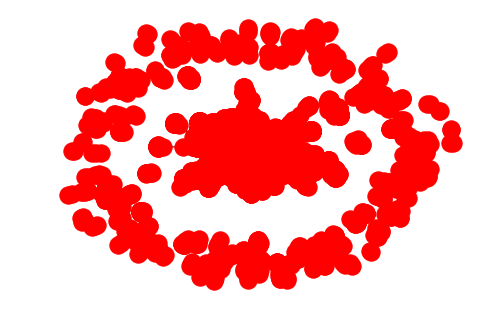

In [69]:
import matplotlib.pyplot as plt

G_Align=nx.Graph()
elist = unique_map
G_Align.add_edges_from(elist)
nx.draw(G_Align)
plt.show()

## compare node and edge connectivity
## compute largest connected component

In [58]:
print('Aligned graph have ',G_Align.number_of_nodes(),' nodes.')
print('Aligned graph have ',G_Align.number_of_edges(),' edges.')

Aligned graph have  4540  nodes.
Aligned graph have  12862  edges.


In [59]:
print('Target graph have ',G_target_na.number_of_nodes(),' nodes.')
print('Target graph have ',G_target_na.number_of_edges(), ' edges.')

Target graph have  4853  nodes.
Target graph have  21536  edges.


In [60]:
sum_weight=0
for i in range(len(unique_xmap)):
    sum_weight=sum_weight+ unique_xmap[i][2]
total_weight=0    
for i in range(len(nd1)):
    for j in range(len(nd2)):
        temp=G_target_na.get_edge_data(str(nd1[i]),str(nd2[j]))
        if(temp!=None):
            total_weight=total_weight+int(list(temp.values())[0])
print('Maximum Weight in Aligned graph: ',sum_weight) 
print('Total Weight in Target: ',total_weight)

Maximum Weight in Aligned graph:  2367955
Total Weight in Target:  3056124


In [61]:
# returns number of different connected components 
print('number of different connected components in Aligned graph: ',nx.number_connected_components(G_Align)) 
print('number of different connected components in Target graph: ',nx.number_connected_components(G_target_na)) 

number of different connected components in Aligned graph:  170
number of different connected components in Target graph:  165


In [62]:
# returns list of nodes in different connected components 
cc_align=list(nx.connected_components(G_Align))
cc_target=list(nx.connected_components(G_target_na))
print(list(nx.connected_components(G_Align))) 
print(list(nx.connected_components(G_target_na)))

[{'hs3165', 'hs7692', 'hs2435', 'hs1580', 'hs1286', 'hs1138', 'hs4409', 'hs5903', 'hs7538', 'hs14625', 'hs1139', 'hs9250', 'hs5965', 'hs16961', 'hs9805', 'hs10732', 'hs775', 'hs401', 'hs10679', 'hs7167', 'hs1381', 'hs11292', 'hs13311', 'hs3881', 'hs15345', 'hs3362', 'hs828', 'hs6209', 'hs14186', 'hs4300', 'hs7021', 'hs10153', 'mm3356', 'hs18255', 'hs7455', 'mm1105', 'hs8547', 'hs6999', 'hs13919', 'hs3331', 'hs2277', 'hs15880', 'hs12825', 'hs1477', 'hs5230', 'hs242', 'hs478', 'hs11901', 'hs7582', 'mm11396', 'hs1225', 'hs1055', 'hs12266', 'mm3071', 'mm11007', 'hs10482', 'hs2841', 'hs7637', 'hs9620', 'hs15527', 'hs9302', 'hs1811', 'hs1128', 'hs7942', 'hs9144', 'hs13517', 'hs11413', 'hs5434', 'hs14887', 'mm17603', 'hs10480', 'hs780', 'hs6932', 'hs65', 'hs6772', 'hs8364', 'hs13840', 'hs4780', 'hs4119', 'hs10712', 'hs6042', 'hs2318', 'hs6597', 'hs3741', 'mm10706', 'hs6435', 'hs9404', 'hs88', 'hs2336', 'hs539', 'hs7900', 'hs1350', 'hs2820', 'hs2610', 'hs3037', 'hs2298', 'hs1617', 'hs6575', 'h

In [63]:
# returns number of nodes to be removed 
# so that Graph becomes disconnected 
print(nx.node_connectivity(G_Align)) 
print(nx.node_connectivity(G_target_na))
# returns number of edges to be removed 
# so that Graph becomes disconnected 
print(nx.edge_connectivity(G_Align))
print(nx.edge_connectivity(G_target_na))

0
0
0
0


# check similarity of connected components

In [64]:
count=0
for i in range(len(cc_align)):
    for j in range(len(cc_target)):
        if(cc_align[i]==cc_target[j]):
            count=count+1
print(count)

164


In [65]:
Gc = max(nx.connected_component_subgraphs(G_Align), key=len)
print('Largest common connected graph in Aligned graph: ',len(Gc))
Gct = max(nx.connected_component_subgraphs(G_target_na), key=len)
print('Largest common connected graph in Target graph: ',len(Gct))

Largest common connected graph in Aligned graph:  3461
Largest common connected graph in Target graph:  3896


### check for mistake align

In [0]:
for i in range(len(unique_map)):
    if (G_target_na.has_edge(unique_map[i][0], unique_map[i][1])==False):
        print(unique_map[i])
        print(i)
print('no exist error')    

# draw graphs

In [0]:
nx.draw_networkx(G1, with_labels = True)

In [0]:
nx.draw_networkx(G2)

In [0]:
import matplotlib.pyplot as plt
nx.draw(G_target_na)
plt.show()

In [66]:
# total ec
total_ec=G_target_na.number_of_edges()/G1.number_of_edges()*100
ratio_ec=score_ec_temp/total_ec*100
print("total EC: ",total_ec)
print("ratio EC: ",ratio_ec)

total EC:  1223.6363636363637
ratio EC:  59.723254086181264


In [67]:
# total ics
total_ics=G_target_na.number_of_edges()/count_induced*100
ratio_ics=score_ics_temp/total_ics*100
print("total ICS: ",total_ics)
print("ratio ICS: ",ratio_ics)

total ICS:  20.419463723593886
ratio ICS:  59.72325408618128


In [68]:
# total s3
total_s3=(G_target_na.number_of_edges()/(G1.number_of_edges()+count_induced-G_target_na.number_of_edges()))*100
ratio_s3=score_s3_temp/total_s3*100
print("total S3: ",total_s3)
print("ratio S3: ",ratio_s3)

total S3:  25.13186761891425
ratio S3:  54.23357023878352


# compute FC

In [1]:
import pickle
with open('mm-hs-weightGraph.pickle', 'rb') as f:
    unique_xmap = pickle.load(f)

In [2]:
tree=[[unique_xmap[i][0],unique_xmap[i][1]] for i in range(len(unique_xmap))]
tree

[['mm7674', 'hs13325'],
 ['mm1225', 'hs3133'],
 ['mm890', 'hs13813'],
 ['mm412', 'hs4620'],
 ['mm12217', 'hs8608'],
 ['mm5368', 'hs2869'],
 ['mm18220', 'hs16880'],
 ['mm5895', 'hs8471'],
 ['mm12658', 'hs5965'],
 ['mm46', 'hs2777'],
 ['mm11480', 'hs546'],
 ['mm303', 'hs1111'],
 ['mm8456', 'hs9945'],
 ['mm7674', 'hs9533'],
 ['mm1051', 'hs1367'],
 ['mm2332', 'hs2863'],
 ['mm7313', 'hs4895'],
 ['mm3300', 'hs4027'],
 ['mm2454', 'hs828'],
 ['mm5831', 'hs6399'],
 ['mm3940', 'hs3161'],
 ['mm3406', 'hs88'],
 ['mm1557', 'hs5828'],
 ['mm1051', 'hs384'],
 ['mm478', 'hs2135'],
 ['mm28', 'hs912'],
 ['mm1226', 'hs2461'],
 ['mm1631', 'hs597'],
 ['mm18269', 'hs16941'],
 ['mm32', 'hs912'],
 ['mm17221', 'hs17772'],
 ['mm1347', 'hs7316'],
 ['mm13853', 'hs16525'],
 ['mm271', 'hs580'],
 ['mm8699', 'hs8796'],
 ['mm2347', 'hs2704'],
 ['mm9309', 'hs8075'],
 ['mm14599', 'hs13137'],
 ['mm2479', 'hs3231'],
 ['mm1295', 'hs6953'],
 ['mm3299', 'hs4034'],
 ['mm5034', 'hs7758'],
 ['mm9112', 'hs912'],
 ['mm17223', 'hs6

# load ontology and create DAG graph

In [3]:
import pandas as pd
f=open('go.dag.obo.txt').readlines()
df=pd.DataFrame(f)
df

,0
0,GO:0046431 GO:0019599\n
1,GO:0046430 GO:0019595\n
2,GO:0046432 GO:0019361\n
3,GO:0034198 GO:0060733\n
4,GO:0046343 GO:0019872\n
5,GO:0034193 GO:0034195\n
6,GO:0034192 GO:0034194\n
7,GO:0034190 GO:0034191\n
8,GO:0046437 GO:0030632 GO:0070179\n
9,GO:0046340 GO:0046342\n


In [4]:
# preprocessing
dag_list=[]
for i in range(len(df[0])):
    m1=str(df[0][i])
    m1=m1.replace('GO:','')
    m1=m1.replace('\n','')
    s=m1.split(' ')
    dag_list.append(s)
dag_list

[['0046431', '0019599'],
 ['0046430', '0019595'],
 ['0046432', '0019361'],
 ['0034198', '0060733'],
 ['0046343', '0019872'],
 ['0034193', '0034195'],
 ['0034192', '0034194'],
 ['0034190', '0034191'],
 ['0046437', '0030632', '0070179'],
 ['0046340', '0046342'],
 ['0030852', '0045658', '0030853', '0045643', '0030854', '0045640'],
 ['0030853', '0045659', '0045644', '0045641'],
 ['0030851', '0030221', '0030223', '0030222'],
 ['0030856',
  '0003339',
  '0030860',
  '0045601',
  '0030857',
  '0072182',
  '0030858',
  '0045616'],
 ['0030857', '0045602', '0030861', '0045617', '0072183'],
 ['0030854', '0045645', '0045642', '0045660'],
 ['0030855',
  '0030859',
  '0030216',
  '0072192',
  '0060671',
  '0072160',
  '0060742',
  '0035026',
  '0072311',
  '0060487',
  '0045446',
  '0060644',
  '0002065'],
 ['0030858', '0045603', '0030862', '0045618'],
 ['0030859', '0045198'],
 ['0031106', '0032186'],
 ['0031105', '0032151', '0032152'],
 ['0031103', '0014814', '0048673', '0014012'],
 ['0031102', '00

In [5]:
dag_nd=[]
for i in range(len(dag_list)):
    for j in range(len(dag_list[i])):
        dag_nd.append(dag_list[i][j])
dag_nodes=set(dag_nd)
print(dag_nodes)
print(len(dag_nodes))

{'0018556', '0018773', '0070100', '0045746', '0042147', '0050357', '0051163', '0033371', '0016210', '0050457', '0034923', '0016672', '0045637', '0031293', '0016643', '0009111', '0050655', '0071128', '0047419', '0004852', '0042371', '0008445', '0035417', '0018474', '0016897', '0048644', '0034785', '0042201', '0004738', '0004739', '0070882', '0008525', '0002345', '0045626', '0045106', '0033178', '0072021', '0018911', '0004725', '0010527', '0047108', '0002577', '0008089', '0031612', '0048074', '0000769', '0032247', '0019364', '0019541', '0006476', '0032776', '0006661', '0023017', '0001316', '0008894', '0045039', '0003243', '0043155', '0019371', '0007371', '0048185', '0007385', '0051024', '0048661', '0010844', '0016496', '0015870', '0034705', '0015655', '0050818', '0032580', '0071728', '0009956', '0050232', '0050715', '0034572', '0052537', '0005705', '0001709', '0004830', '0001789', '0075292', '0048072', '0032207', '0048288', '0021619', '0022408', '0008692', '0046892', '0001801', '0047287'

In [6]:
# create dag edges
dag_edges=[]
for i in range(len(dag_list)):
    for j in range(1,len(dag_list[i])):
        ed=[dag_list[i][0],dag_list[i][j]]
        dag_edges.append(ed)
dag_edges

[['0046431', '0019599'],
 ['0046430', '0019595'],
 ['0046432', '0019361'],
 ['0034198', '0060733'],
 ['0046343', '0019872'],
 ['0034193', '0034195'],
 ['0034192', '0034194'],
 ['0034190', '0034191'],
 ['0046437', '0030632'],
 ['0046437', '0070179'],
 ['0046340', '0046342'],
 ['0030852', '0045658'],
 ['0030852', '0030853'],
 ['0030852', '0045643'],
 ['0030852', '0030854'],
 ['0030852', '0045640'],
 ['0030853', '0045659'],
 ['0030853', '0045644'],
 ['0030853', '0045641'],
 ['0030851', '0030221'],
 ['0030851', '0030223'],
 ['0030851', '0030222'],
 ['0030856', '0003339'],
 ['0030856', '0030860'],
 ['0030856', '0045601'],
 ['0030856', '0030857'],
 ['0030856', '0072182'],
 ['0030856', '0030858'],
 ['0030856', '0045616'],
 ['0030857', '0045602'],
 ['0030857', '0030861'],
 ['0030857', '0045617'],
 ['0030857', '0072183'],
 ['0030854', '0045645'],
 ['0030854', '0045642'],
 ['0030854', '0045660'],
 ['0030855', '0030859'],
 ['0030855', '0030216'],
 ['0030855', '0072192'],
 ['0030855', '0060671'],


In [7]:
import networkx as nx
go=nx.DiGraph()
go.add_nodes_from(dag_nodes)
go.add_edges_from(dag_edges)
go

In [8]:
c=0
import numpy as np
na=tree
for i in range(len(tree)):
    for j in range(2):
        if ('hs' in tree[i][j] or 'mm' in tree[i][j]):
            s=tree[i][j][2:]
            x='0'*(7-len(s))
            y=x+s
            #print(y)
            na[i][j]=y
            c=c+1
print(len(tree),c)
print(len(na))

12954 25908
12954


In [9]:
fc=[]
for i in range(len(na)):
    if na[i][0] in dag_nodes:
        e=go.predecessors(na[i][0])
        if na[i][1] in dag_nodes: 
            f=go.predecessors(na[i][1])
            temp=[]
            for key in e:
                temp.append(key)
            for key in f:
                temp.append(key)
            # compute intersection/union 
            fc.append(sum([temp.count(temp[z])/len(temp) for z in range(len(temp))]))
        else:
            fc.append(0)
#print(fc)
# compute average of all fc 
func=np.average(fc)
print('functional coherence:',func)

functional coherence: 0.6260162102419256
